# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# B. Forecasting Temperatures in Athens for the year 2016

## Importing Data

In [2]:
athens = pd.read_csv('CSVs/Athens.csv')

In [3]:
athens.head()

,Set Number,Subset Type,Day of Week,Shape,Values,Source CSV,Values_Celsius
0,1,7 days,Monday,"(24, 301, 301)",280.20355,2012_01_tas_subset.csv,7.05355
1,2,7 days,Monday,"(24, 301, 301)",279.47733,2012_01_tas_subset.csv,6.32733
2,3,7 days,Monday,"(24, 301, 301)",275.68347,2012_01_tas_subset.csv,2.53347
3,4,7 days,Monday,"(24, 301, 301)",283.89767,2012_01_tas_subset.csv,10.74767
4,5,7 days,Monday,"(24, 301, 301)",275.69302,2012_01_tas_subset.csv,2.54302


In [4]:
athens['Year'] = athens['Source CSV'].str.split('_').str[0]
athens['Month'] = athens['Source CSV'].str.split('_').str[1]
athens.head()

,Set Number,Subset Type,Day of Week,Shape,Values,Source CSV,Values_Celsius,Year,Month
0,1,7 days,Monday,"(24, 301, 301)",280.20355,2012_01_tas_subset.csv,7.05355,2012,01
1,2,7 days,Monday,"(24, 301, 301)",279.47733,2012_01_tas_subset.csv,6.32733,2012,01
2,3,7 days,Monday,"(24, 301, 301)",275.68347,2012_01_tas_subset.csv,2.53347,2012,01
3,4,7 days,Monday,"(24, 301, 301)",283.89767,2012_01_tas_subset.csv,10.74767,2012,01
4,5,7 days,Monday,"(24, 301, 301)",275.69302,2012_01_tas_subset.csv,2.54302,2012,01


In [5]:
columns_to_drop = ['Set Number', 'Subset Type', 'Day of Week', 'Shape', 'Values', 'Source CSV']
athens.drop(columns_to_drop, axis=1, inplace=True)
athens.rename(columns={'Values_Celsius': 'Temperature'}, inplace=True)
athens['Temperature'] = np.round(athens['Temperature'], 2)
athens.head()

,Temperature,Year,Month
0,7.05,2012,01
1,6.33,2012,01
2,2.53,2012,01
3,10.75,2012,01
4,2.54,2012,01


In [6]:
athens['Date'] = pd.to_datetime(athens['Year'].astype(str) + athens['Month'].astype(str).str.zfill(2), format='%Y%m')

athens['Week'] = athens.groupby('Year').cumcount() + 1
columns_to_drop = ['Date']
athens.drop(columns_to_drop, axis=1, inplace=True)

athens.head(20)

,Temperature,Year,Month,Week
0,7.05,2012,01,1
1,6.33,2012,01,2
2,2.53,2012,01,3
3,10.75,2012,01,4
4,2.54,2012,01,5
5,11.26,2012,02,6
6,10.05,2012,02,7
7,9.29,2012,02,8
8,7.94,2012,02,9
9,10.72,2012,03,10


## Splitting Data

In [7]:
athens['Year'] = athens['Year'].astype(int)
athens = athens[athens['Year'].between(2012, 2016)].copy().reset_index(drop=True)
train = athens[athens['Year'].between(2012, 2015)].copy().reset_index(drop=True)
forecast = athens[athens['Year'] == 2016].copy().reset_index(drop=True)

print("DataFrame for 2012-2015:")
train.head()

DataFrame for 2012-2015:


,Temperature,Year,Month,Week
0,7.05,2012,01,1
1,6.33,2012,01,2
2,2.53,2012,01,3
3,10.75,2012,01,4
4,2.54,2012,01,5


In [8]:
print("DataFrame for 2016:")
forecast.head()

DataFrame for 2016:


,Temperature,Year,Month,Week
0,11.96,2016,01,1
1,14.09,2016,01,2
2,3.59,2016,01,3
3,3.93,2016,01,4
4,13.24,2016,02,5


## B. a) Forecasting Temperatures in Athens for the year 2016 
### Approaches Used: 
### i) Moving Average ii) Optimized Moving Average iii) Simple Exponential Smoothing iv) Optimized Simple Exponential Smoothing v) Naive

### i) Moving Average

In [9]:
def ma(actual, periods, window):
    temp = actual[-window:]
    
    for _ in range(periods):
        ma = np.mean(temp[-window:])
        temp = np.append(temp, ma)
    
    ma = np.array(temp[-periods:])
    return ma


forecast['MA_5'] = ma(np.array(train['Temperature']), forecast.shape[0], 5)

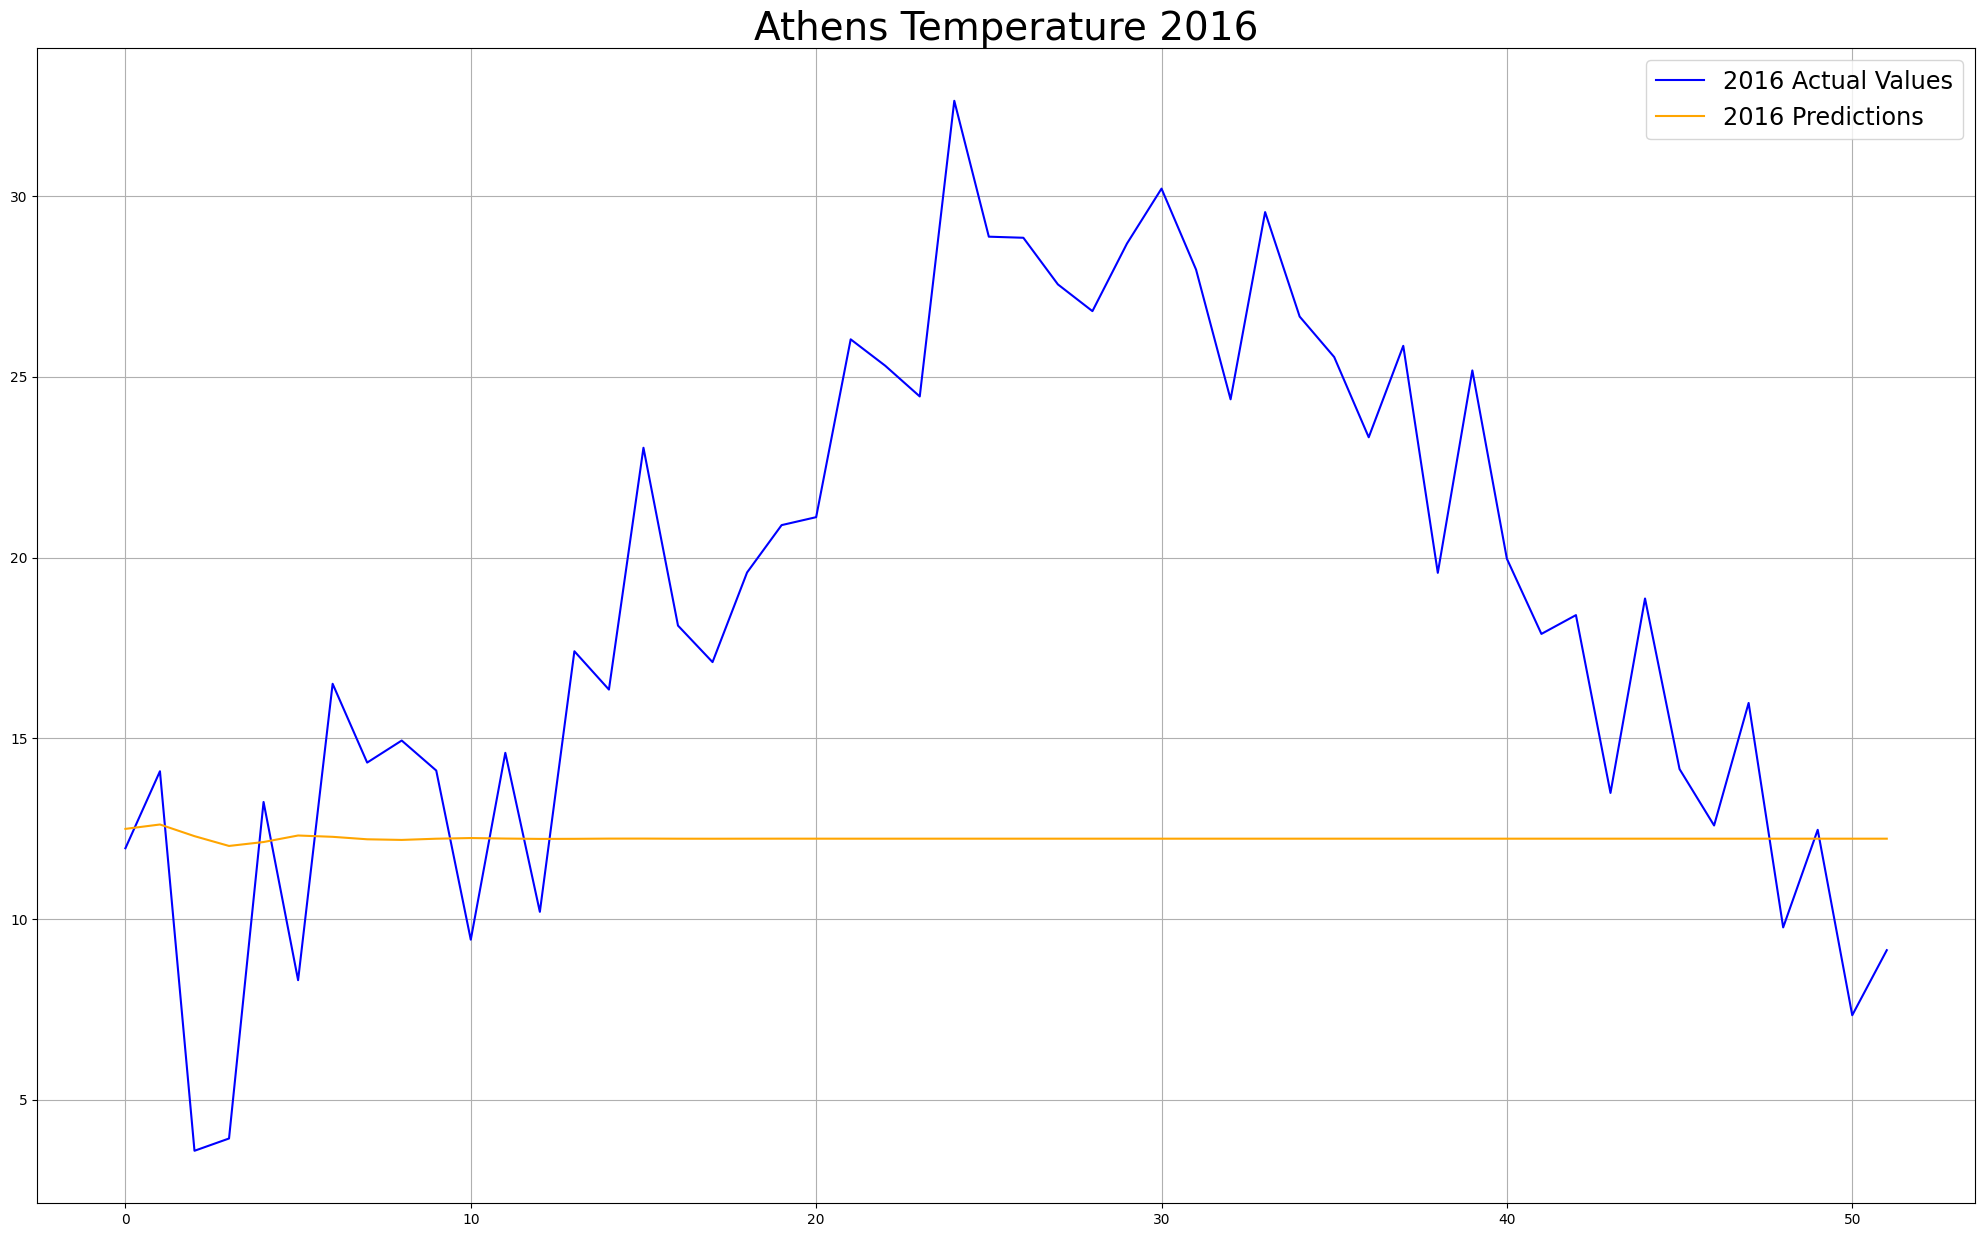

In [10]:
plt.figure(figsize=(25,15))
plt.plot(forecast["Temperature"], color = "blue",label='2016 Actual Values')
plt.plot(forecast["MA_5"], color = "orange",label='2016 Predictions')
plt.title('Athens Temperature 2016', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

### ii) Optimized Moving Average

In [11]:
save_progress = pd.DataFrame(columns=['Window', 'MAD'])
save_i = 0
save_mad = 90000
for i in range(2,200):
    temp_forecast = ma(np.array(train['Temperature']), forecast.shape[0], i)
    mad = np.mean(np.abs(temp_forecast - forecast['Temperature']))
    save_progress = pd.concat([save_progress, pd.DataFrame({'Window': [i], 'MAD': [mad]})], ignore_index=True)
    if mad < save_mad:
        save_mad = mad
        save_i = i
    

print(f"Best window: {save_i}, with Mean Absolute Deviation: {save_mad}")


Best window: 62, with Mean Absolute Deviation: 5.4422239421241105


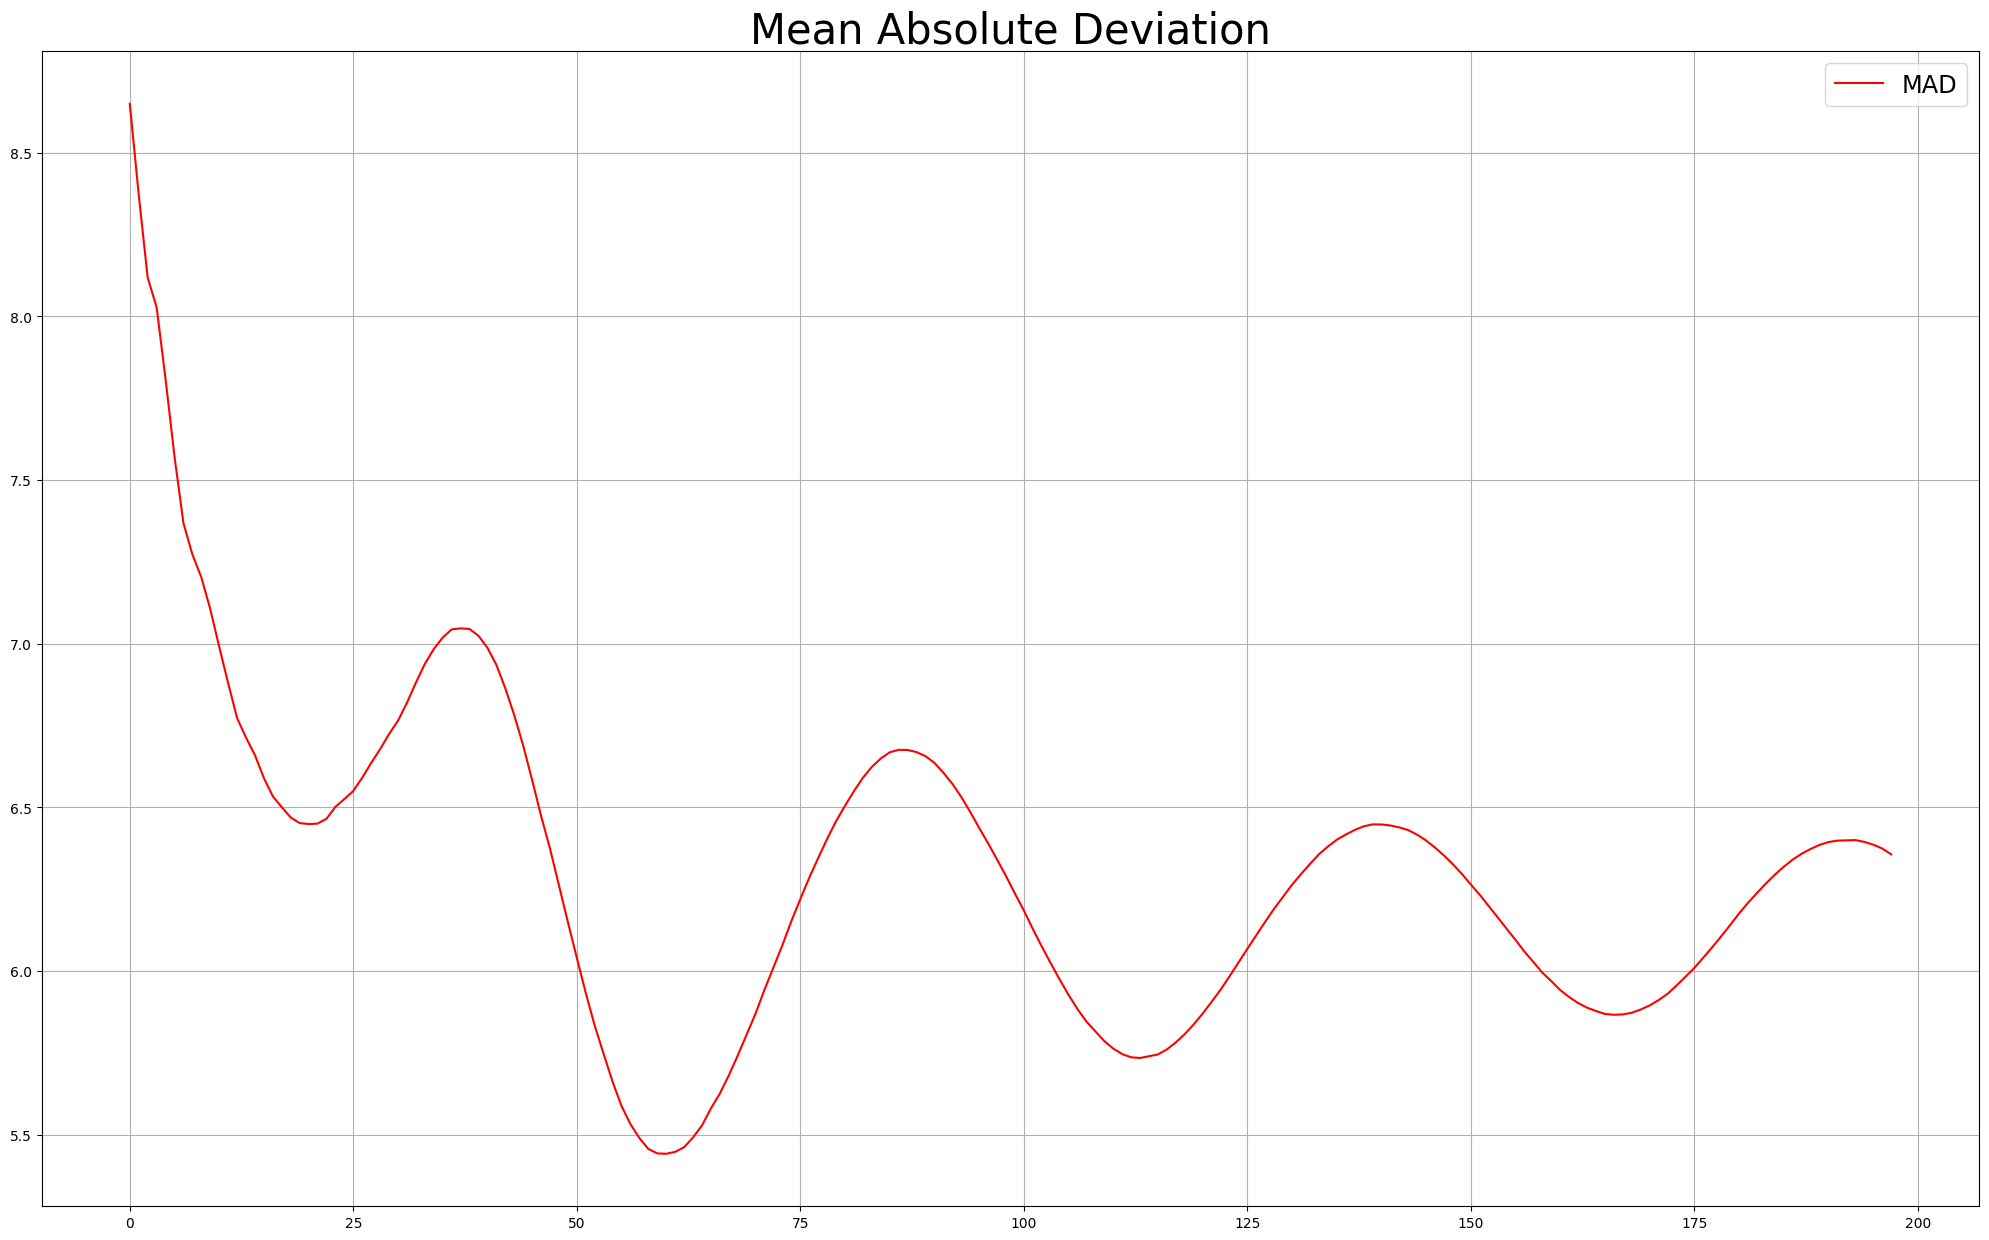

In [12]:
plt.figure(figsize=(25,15))
plt.plot(save_progress["MAD"], color = "red", label='MAD')
plt.title('Mean Absolute Deviation', size=30, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

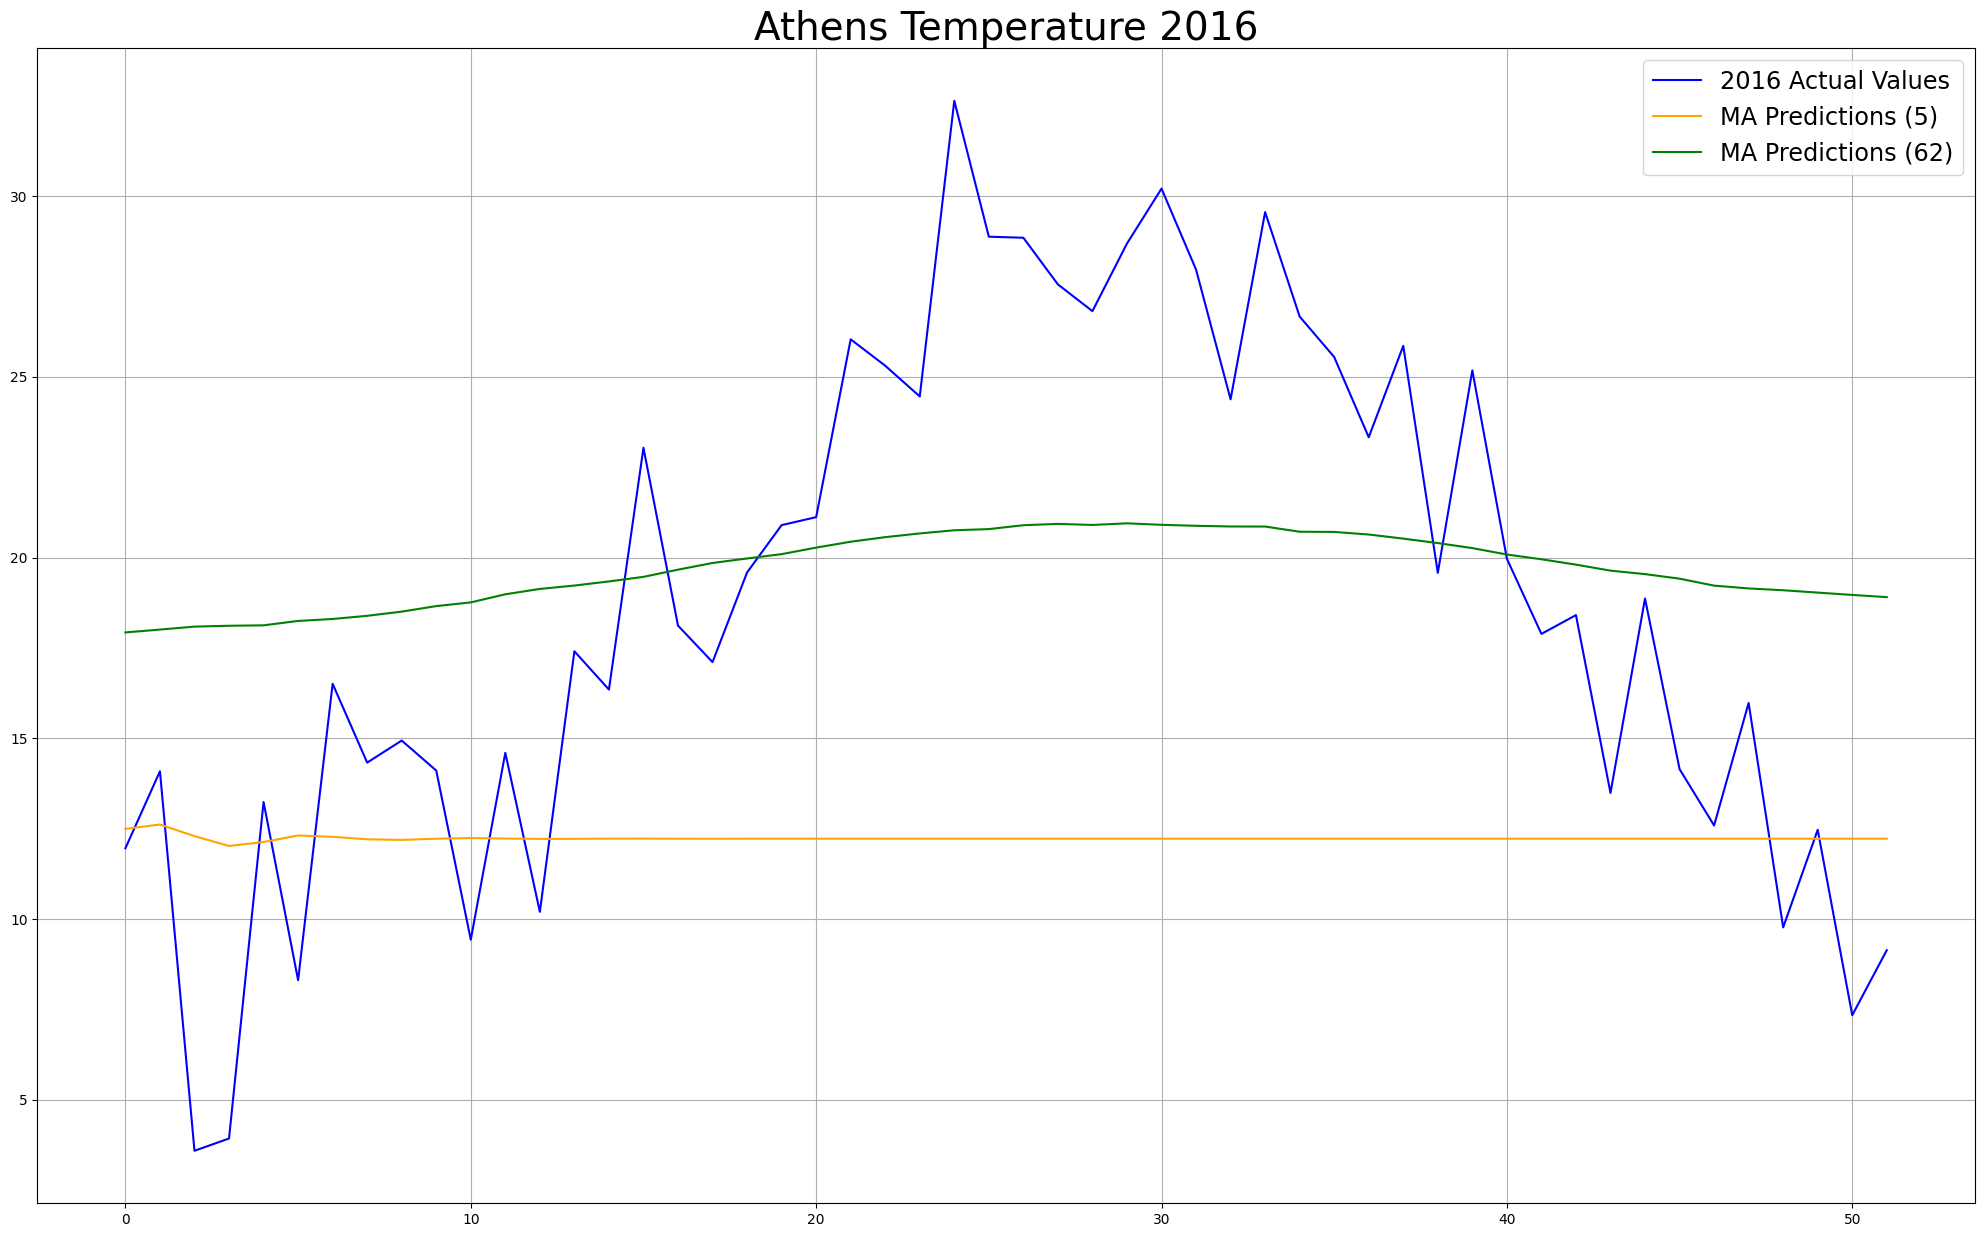

In [13]:
forecast['MA_62'] = ma(np.array(train['Temperature']), forecast.shape[0], 62)

plt.figure(figsize=(25,15))
plt.plot(forecast["Temperature"], color = "blue",label='2016 Actual Values')
plt.plot(forecast["MA_5"], color = "orange",label='MA Predictions (5)')
plt.plot(forecast["MA_62"], color = "green",label='MA Predictions (62)')
plt.title('Athens Temperature 2016', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

### iii) Simple Exponential Smoothing

In [14]:
def simple_expo_smooth(actual, periods, a):
    f_t = 0
    f = np.array(actual[0])
    f_t = a*actual[0] + (1 - a)*f
    f = np.append(f, f_t)
    for i in actual[1:]:
        f_t = a*i + (1 - a)*f[-1]
        f = np.append(f, f_t)
    for _ in range(periods):
        f_t = a*actual[-1] + (1 - a)*f[-1]
        f = np.append(f, f_t)
    return f[1:]

athens['ExpoSmooth 0.5'] = simple_expo_smooth(np.array(train['Temperature']), forecast.shape[0], 0.5)

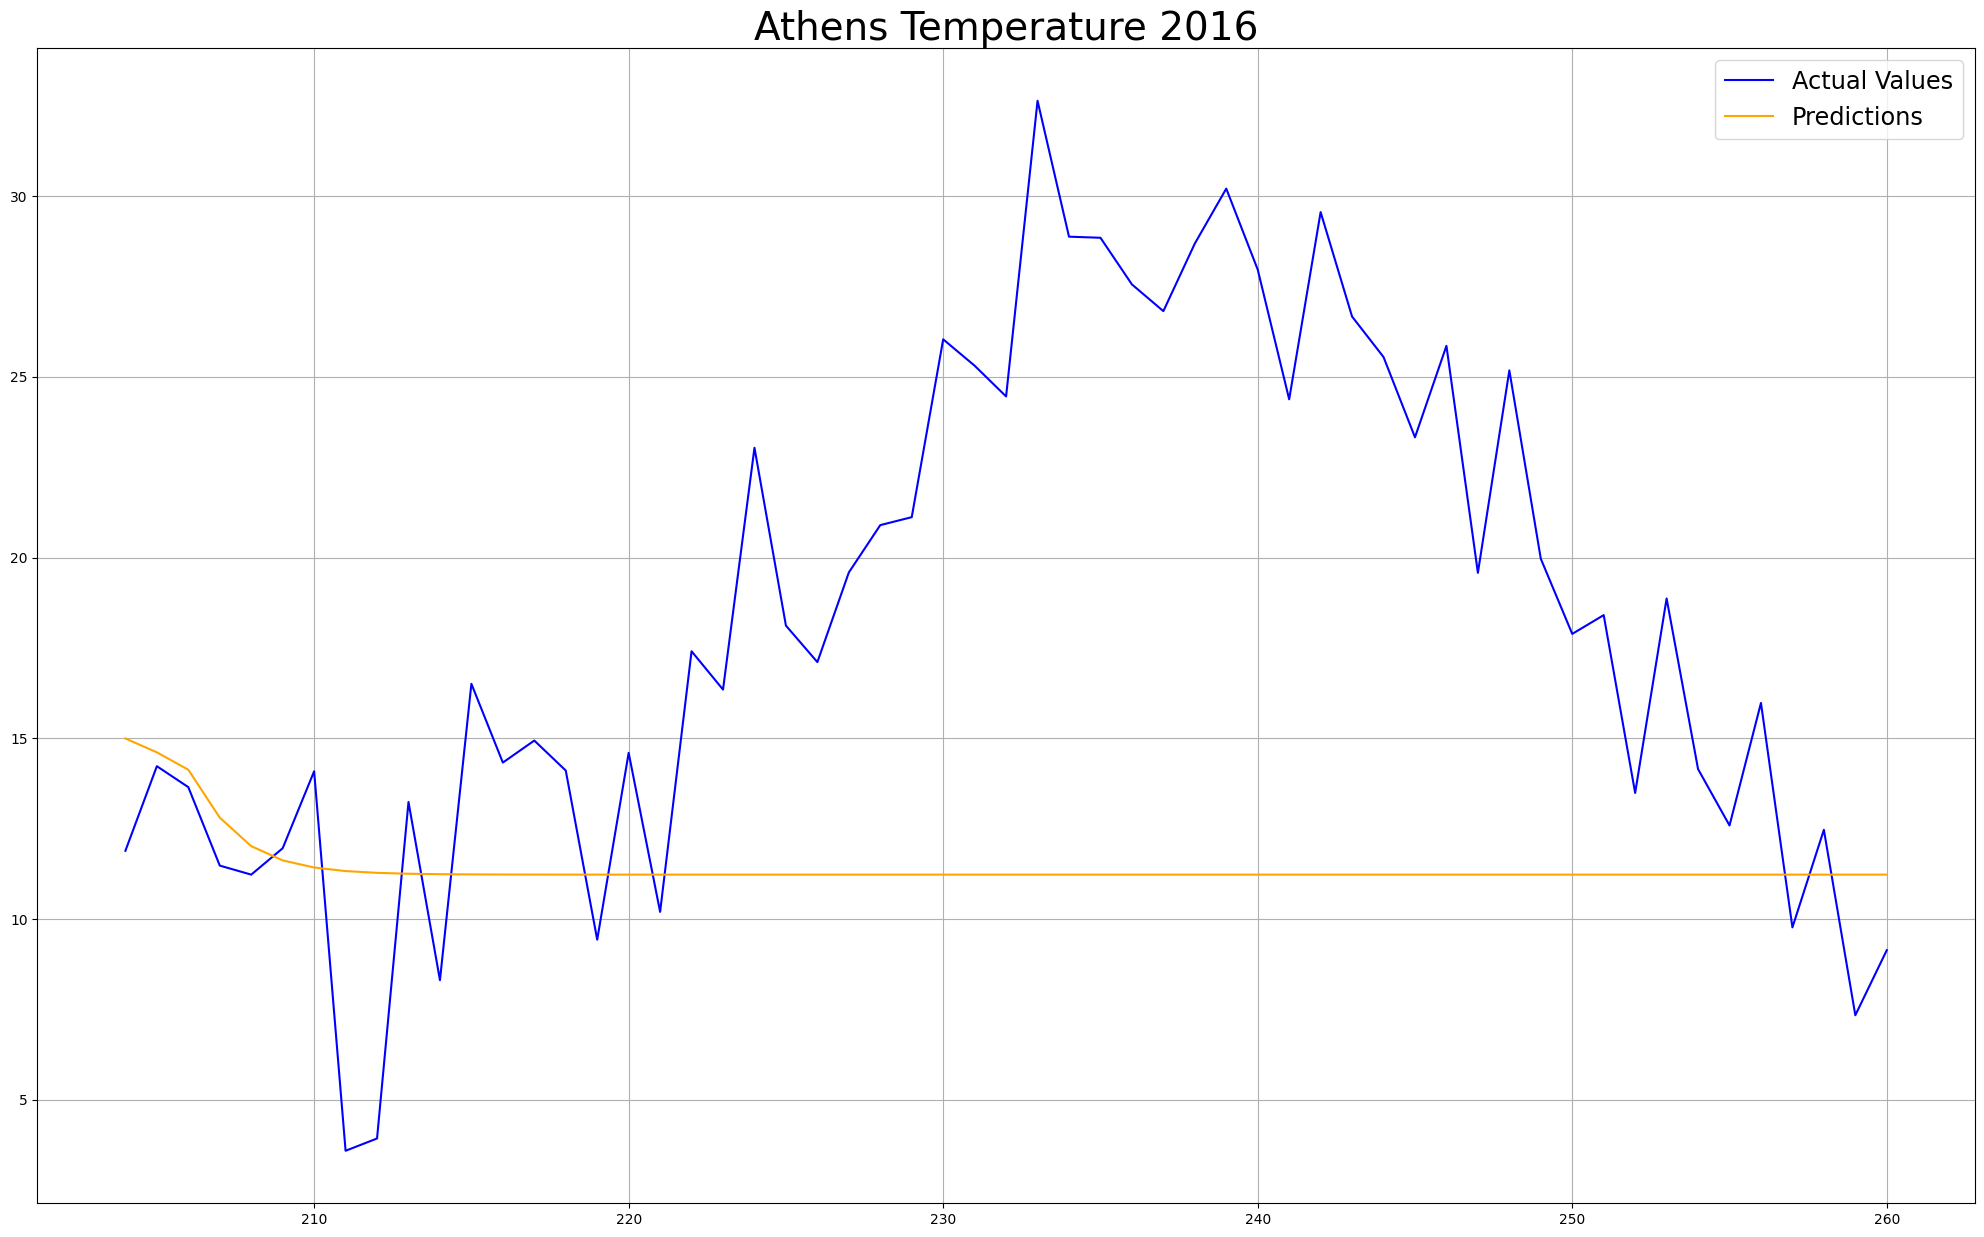

In [15]:
plt.figure(figsize=(25,15))
plt.plot(athens["Temperature"][-(forecast.shape[0]+5):], color = "blue",label='Actual Values')
plt.plot(athens['ExpoSmooth 0.5'][-(forecast.shape[0]+5):], color = "orange",label='Predictions')
plt.title('Athens Temperature 2016', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

### iv) Optimized Simple Exponential Smoothing

In [16]:
save_progress_expo = pd.DataFrame(columns=['Window', 'MAD'])
save_i = 0
save_mad = 90000
for i in np.arange(0.01,1,0.01):
    temp_forecast = simple_expo_smooth(np.array(train['Temperature']), forecast.shape[0], i)
    mad = np.mean(np.abs(temp_forecast[-forecast.shape[0]:] - forecast['Temperature']))
    save_progress_expo = pd.concat([save_progress_expo, pd.DataFrame({'Window': [i], 'MAD': [mad]})], ignore_index=True)
    if mad < save_mad:
        save_mad = mad
        save_i = i
    

print(f"Best window: {save_i}, with Mean Absolute Deviation: {save_mad}")

Best window: 0.01, with Mean Absolute Deviation: 6.608450296277966


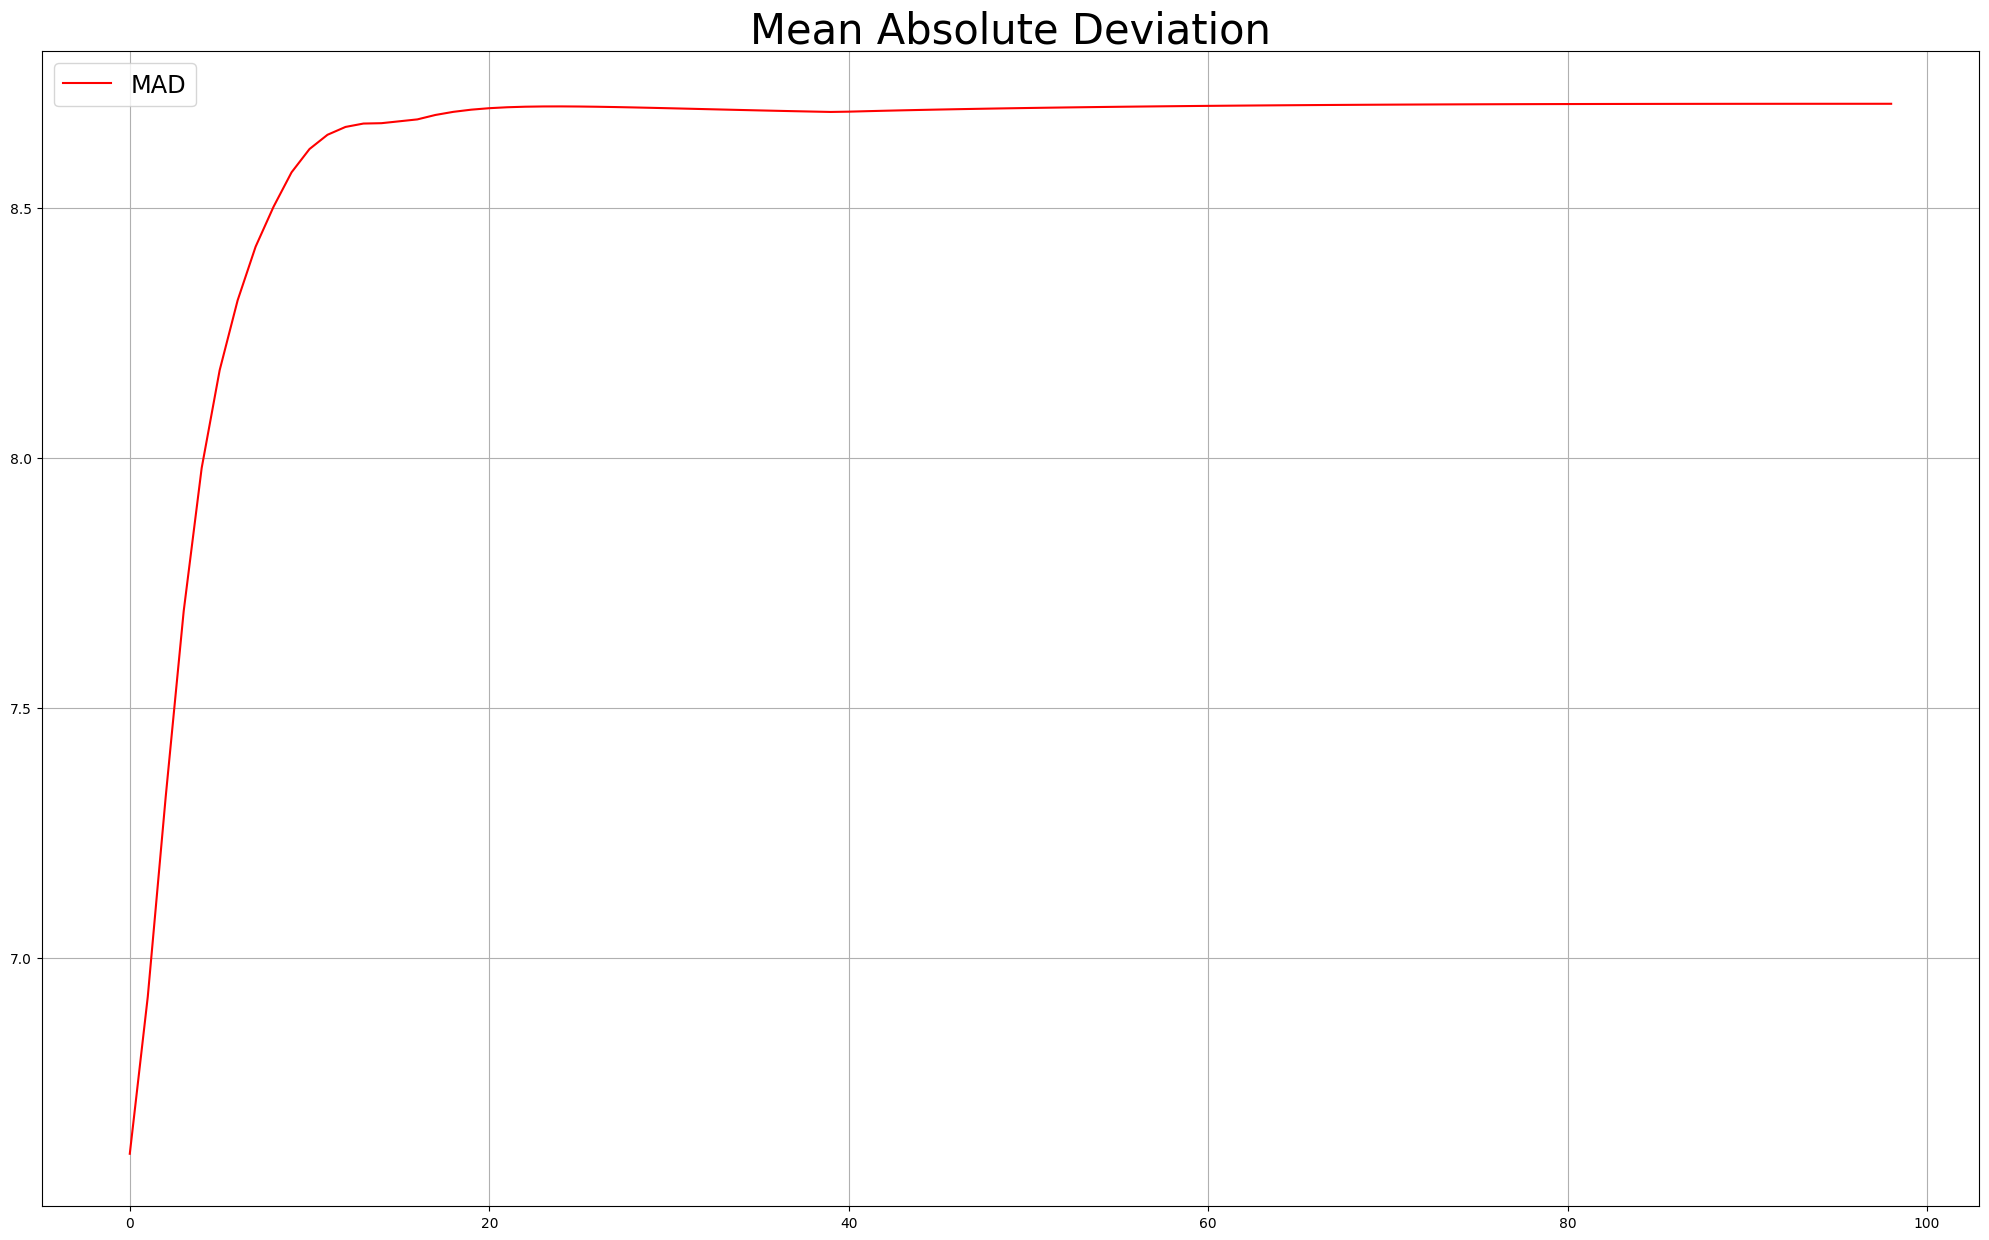

In [17]:
plt.figure(figsize=(25,15))
plt.plot(save_progress_expo["MAD"], color = "red",label='MAD')
plt.title('Mean Absolute Deviation', size=30, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

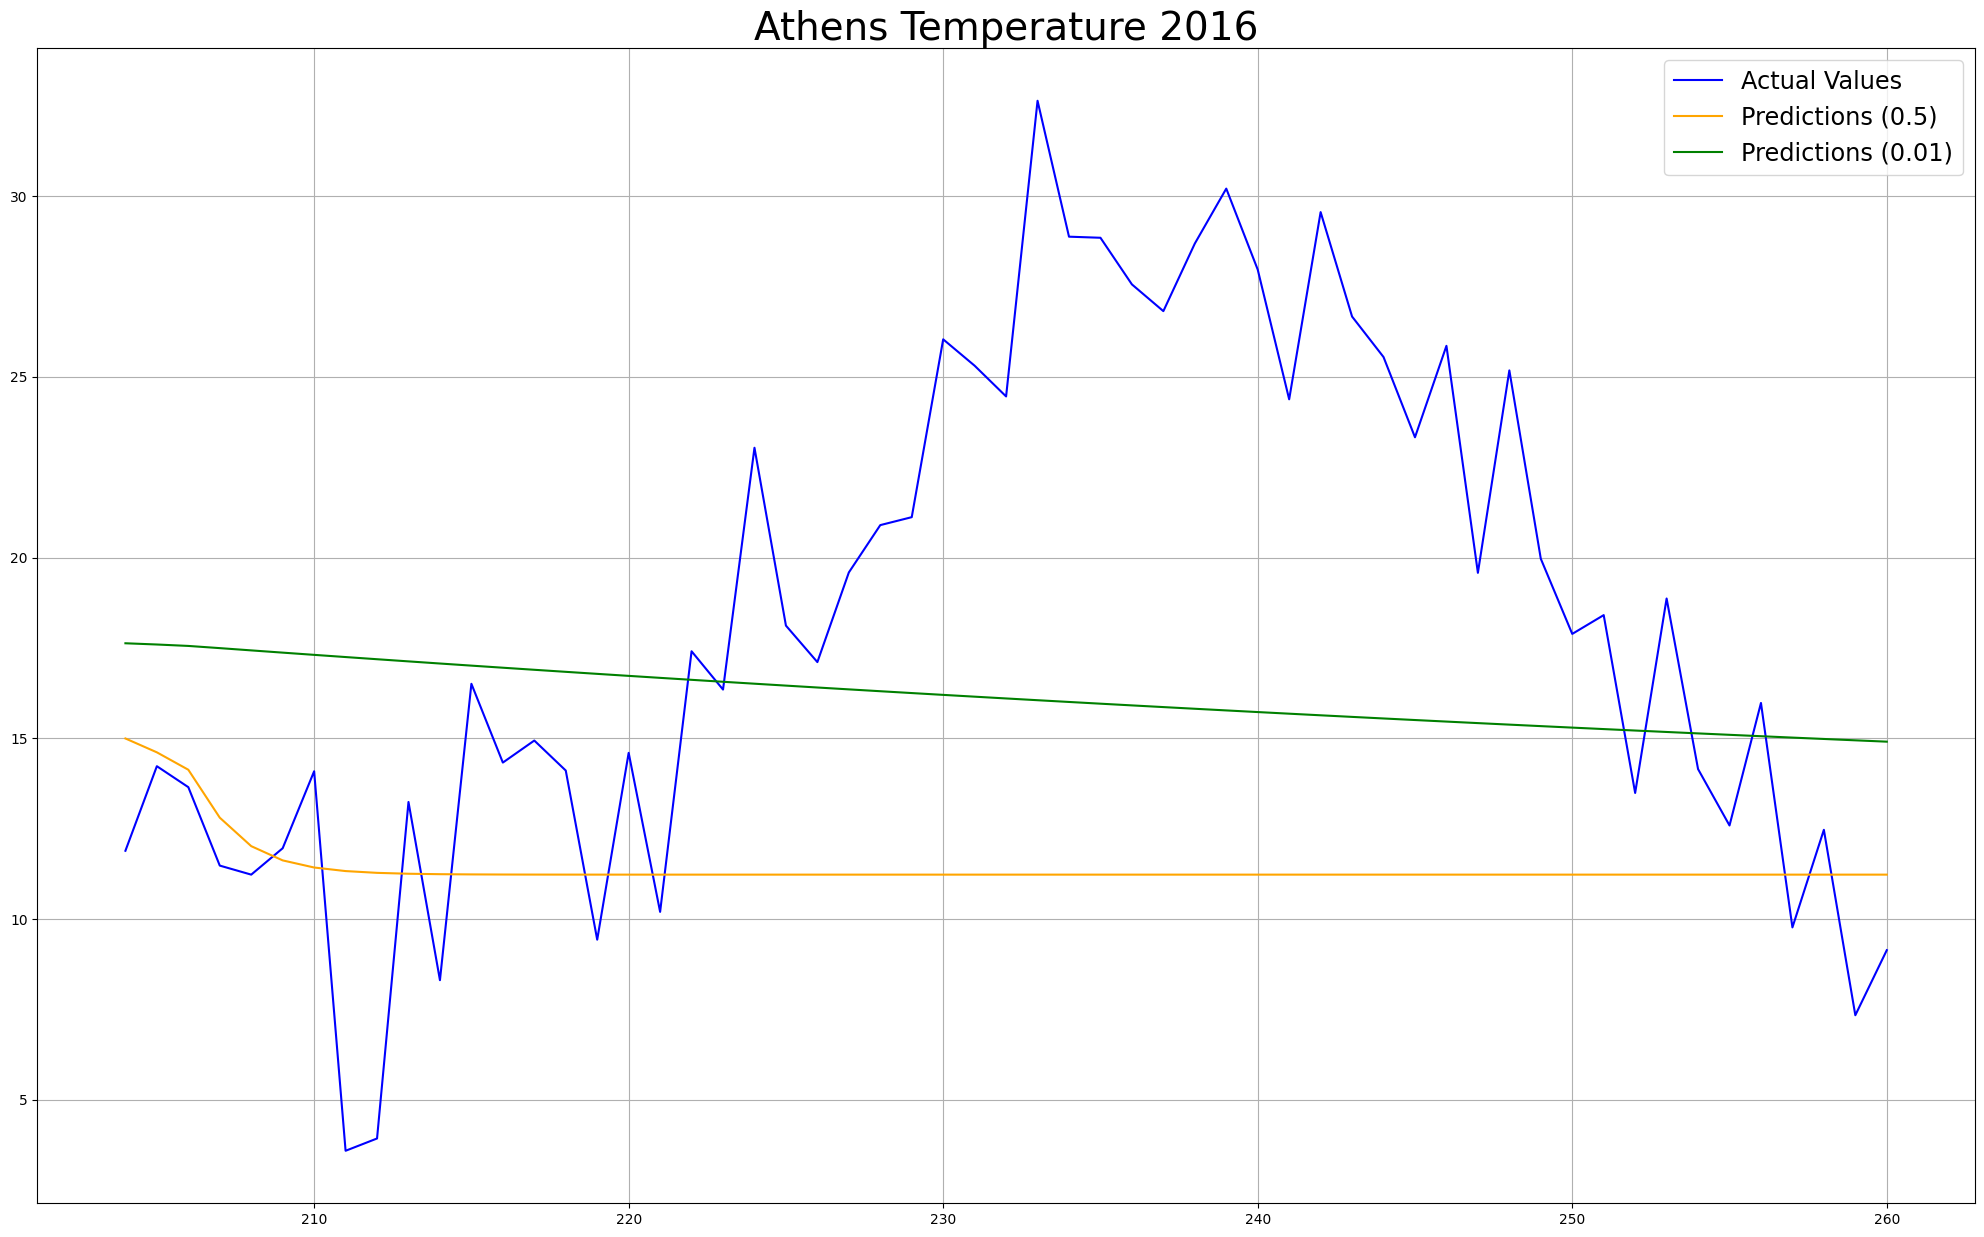

In [18]:
athens['ExpoSmooth 0.01'] = simple_expo_smooth(np.array(train['Temperature']), forecast.shape[0], 0.01)

plt.figure(figsize=(25,15))
plt.plot(athens["Temperature"][-(forecast.shape[0]+5):], color = "blue",label='Actual Values')
plt.plot(athens['ExpoSmooth 0.5'][-(forecast.shape[0]+5):], color = "orange",label='Predictions (0.5)')
plt.plot(athens['ExpoSmooth 0.01'][-(forecast.shape[0]+5):], color = "green",label='Predictions (0.01)')
plt.title('Athens Temperature 2016', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

### v) Naive

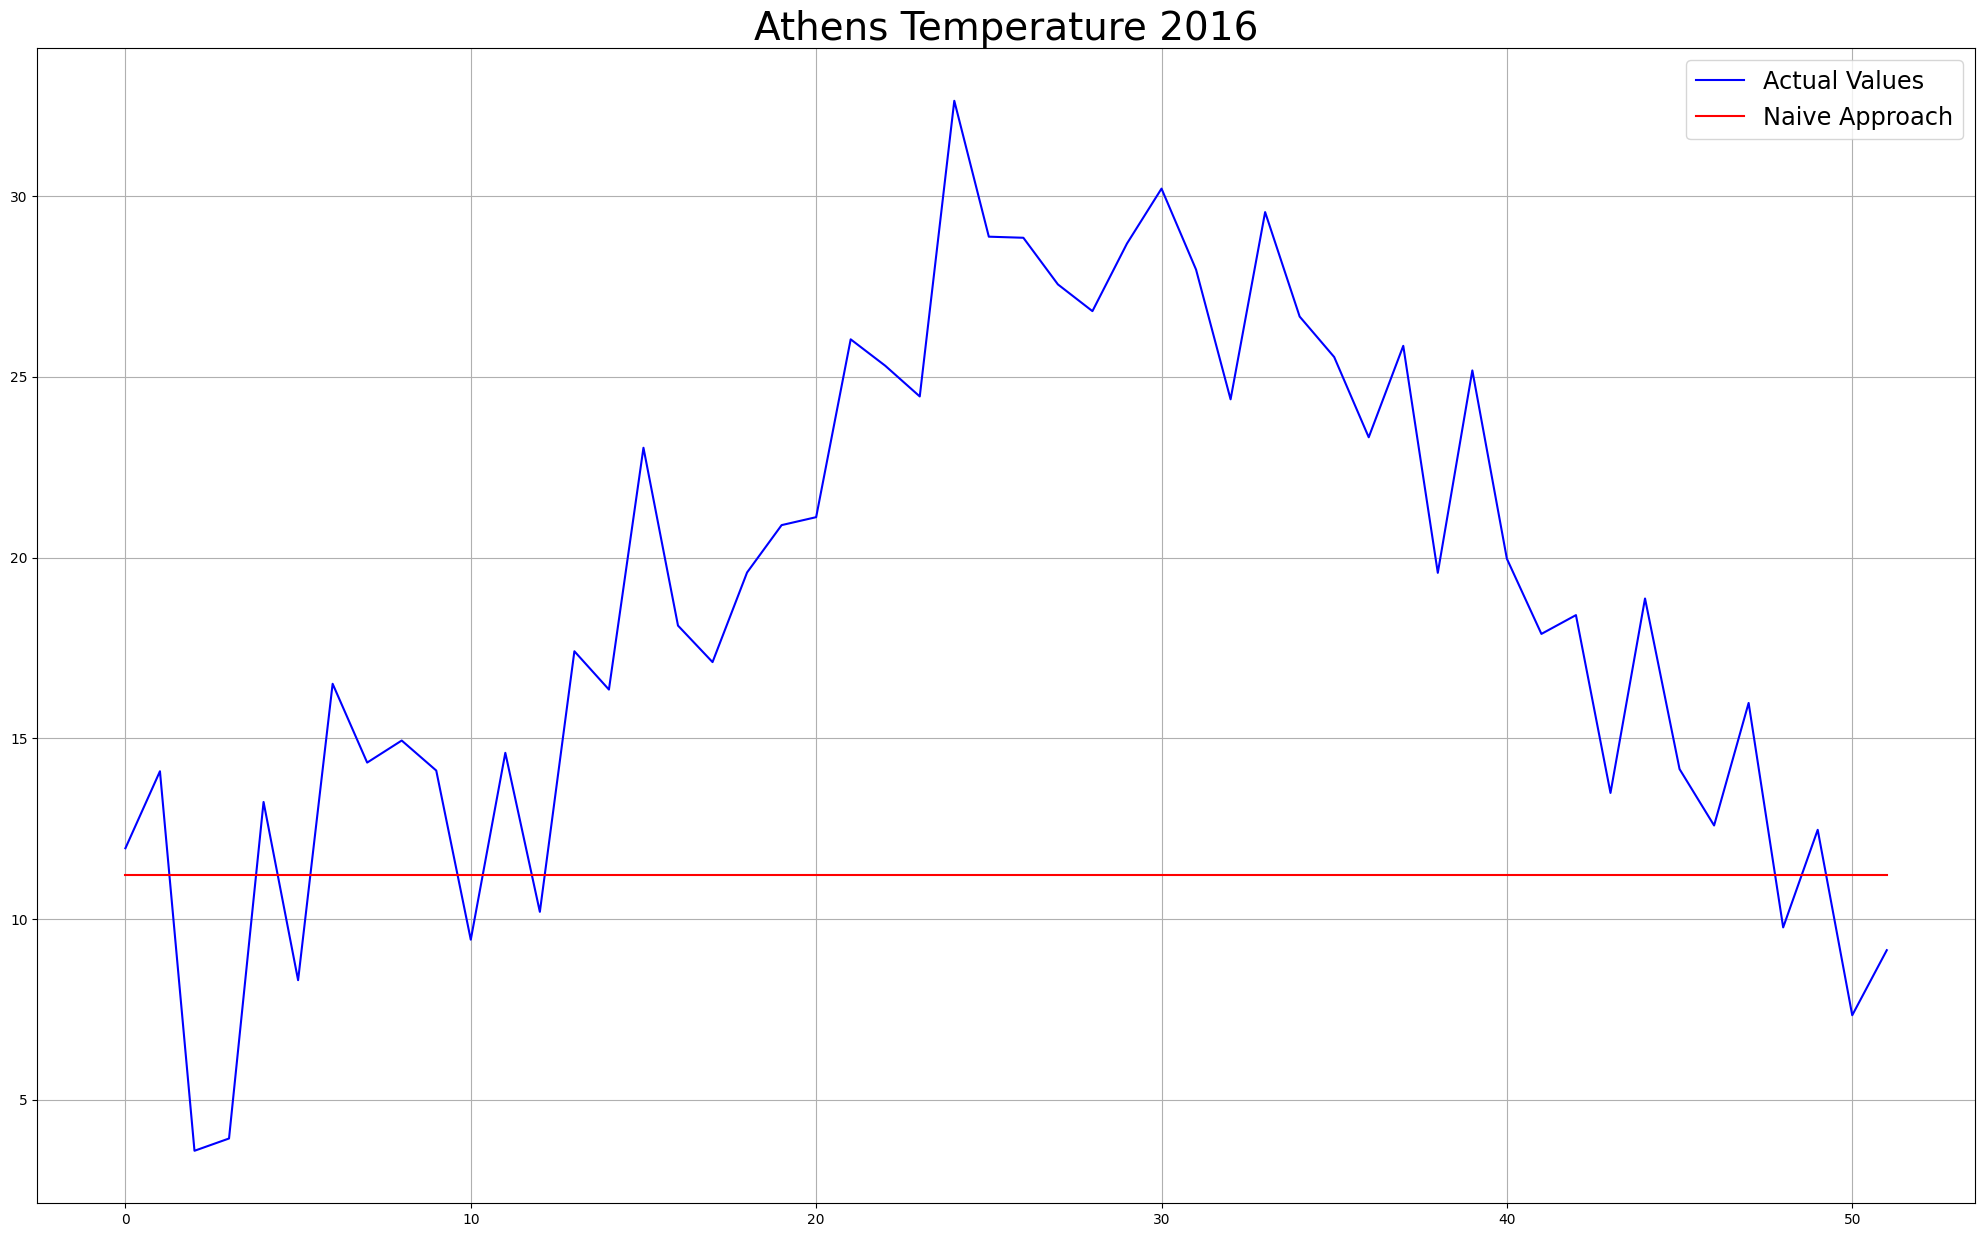

In [19]:
forecast['Naive'] = np.ones(forecast.shape[0])*float(train['Temperature'][-1:])

plt.figure(figsize=(25,15))
plt.plot(forecast["Temperature"], color = "blue",label='Actual Values')
plt.plot(forecast['Naive'], color = "red",label='Naive Approach')
plt.title('Athens Temperature 2016', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

## B. b) Forecasting Temperatures in Athens for the year 2016
### Approach Comparison - Error Estimations

In [20]:
### Mean Absolute Deviation ###

def mad(forecasts, actuals):
    mad = np.mean(np.abs(forecasts - actuals))
    return mad

### Mean Squared Error ###

def mse(forecasts, actuals):
    mse = np.mean(np.square(forecasts - actuals))
    return mse

### Root Mean Squared Error ###

def rmse(forecasts, actuals):
    rmse = np.sqrt(np.mean(np.square(forecasts - actuals)))
    return rmse

### Mean Absolute Percentage Error ###

def mape(forecasts, actuals):
    mape = np.mean(np.abs((forecasts - actuals)/actuals)*100)
    return mape

In [21]:
errors = pd.DataFrame(columns = ['mad', 'mse', 'rmse', 'mape'], index = ['Moving Average 5',
                                                                         'Moving Average 62',
                                                                         'Exponential Smoothing 0.5',
                                                                         'Exponential Smoothing 0.01',
                                                                         'Naive Approach',
                                                                         'TrendExpoSmooth 0.5, 0.5',
                                                                         'TrendExpoSmooth 0.01, 0.08',
                                                                         'SeasonExpoSmooth 0.5, 0.5, 0.5',
                                                                         'Optimized SeasonExpoSmooth',
                                                                         'Amsterdam Forecast',
                                                                         'Amsterdam Improved Forecast',
                                                                         'Mean Temperatures'])

In [22]:
errors['mad']['Moving Average 5'] = np.round(mad(forecast['MA_5'], forecast['Temperature']), 2)
errors['mad']['Moving Average 62'] = np.round(mad(forecast['MA_62'], forecast['Temperature']), 2)
errors['mad']['Exponential Smoothing 0.5'] = np.round(mad(athens['ExpoSmooth 0.5'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['mad']['Exponential Smoothing 0.01'] = np.round(mad(athens['ExpoSmooth 0.01'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['mse']['Moving Average 5'] = np.round(mse(forecast['MA_5'], forecast['Temperature']), 2)
errors['mse']['Moving Average 62'] = np.round(mse(forecast['MA_62'], forecast['Temperature']), 2)
errors['mse']['Exponential Smoothing 0.5'] = np.round(mse(athens['ExpoSmooth 0.5'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['mse']['Exponential Smoothing 0.01'] = np.round(mse(athens['ExpoSmooth 0.01'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['rmse']['Moving Average 5'] = np.round(rmse(forecast['MA_5'], forecast['Temperature']), 2)
errors['rmse']['Moving Average 62'] = np.round(rmse(forecast['MA_62'], forecast['Temperature']), 2)
errors['rmse']['Exponential Smoothing 0.5'] = np.round(rmse(athens['ExpoSmooth 0.5'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['rmse']['Exponential Smoothing 0.01'] = np.round(rmse(athens['ExpoSmooth 0.01'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['mape']['Moving Average 5'] = str(np.round(mape(forecast['MA_5'], forecast['Temperature']), 2)) + '%'
errors['mape']['Moving Average 62'] = str(np.round(mape(forecast['MA_62'], forecast['Temperature']), 2)) + '%'
errors['mape']['Exponential Smoothing 0.5'] = str(np.round(mape(athens['ExpoSmooth 0.5'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)) + '%'
errors['mape']['Exponential Smoothing 0.01'] = str(np.round(mape(athens['ExpoSmooth 0.01'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)) + '%'
errors['mad']['Naive Approach'] = np.round(mad(forecast['Naive'], forecast['Temperature']), 2)
errors['mse']['Naive Approach'] = np.round(mse(forecast['Naive'], forecast['Temperature']), 2)
errors['rmse']['Naive Approach'] = np.round(rmse(forecast['Naive'], forecast['Temperature']), 2)
errors['mape']['Naive Approach'] = str(np.round(mape(forecast['Naive'], forecast['Temperature']), 2)) + '%'

errors.head(5)

,mad,mse,rmse,mape
Moving Average 5,8.03,96.39,9.82,43.81%
Moving Average 62,5.44,41.71,6.46,46.15%
Exponential Smoothing 0.5,8.7,110.63,10.52,45.82%
Exponential Smoothing 0.01,6.61,63.74,7.98,45.48%
Naive Approach,8.71,110.62,10.52,45.84%


## B. c) Forecasting Temperatures in Athens for the year 2016
### Trend Adjustment - Holt’s Model

In [23]:
# initial estimate of Lo level and To trend by running a linear regression

def find_ab(lis):
    y = np.array(lis).reshape(len(lis),1)
    x = np.arange(len(lis)).reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    # coefficient of determination
    r_sq = model.score(x, y)
    # coefficient To
    To = model.coef_[0][0]
    # intercept Lo
    Lo = model.intercept_[0]
    return To, Lo

def trend_expo_smooth(actual, periods, Lo, To, a, b):
    L = Lo
    T = To

    L = np.append(L, a * actual[1] + (1 - a) * (L + T))
    T = np.append(T, b * (L[1] - L[0]) + (1 - b) * T)

    for i in range(1, len(actual) - 1):
        L = np.append(L, a * actual[i + 1] + (1 - a) * (L[i] + T[i]))
        T = np.append(T, b * (L[i + 1] - L[i]) + (1 - b) * T[i])

    Tt = T[-1]
    for i in range(periods):
        L = np.append(L, L[-1])
        T = np.append(T, Tt*(i +1))

    forecast = L + T
    return forecast

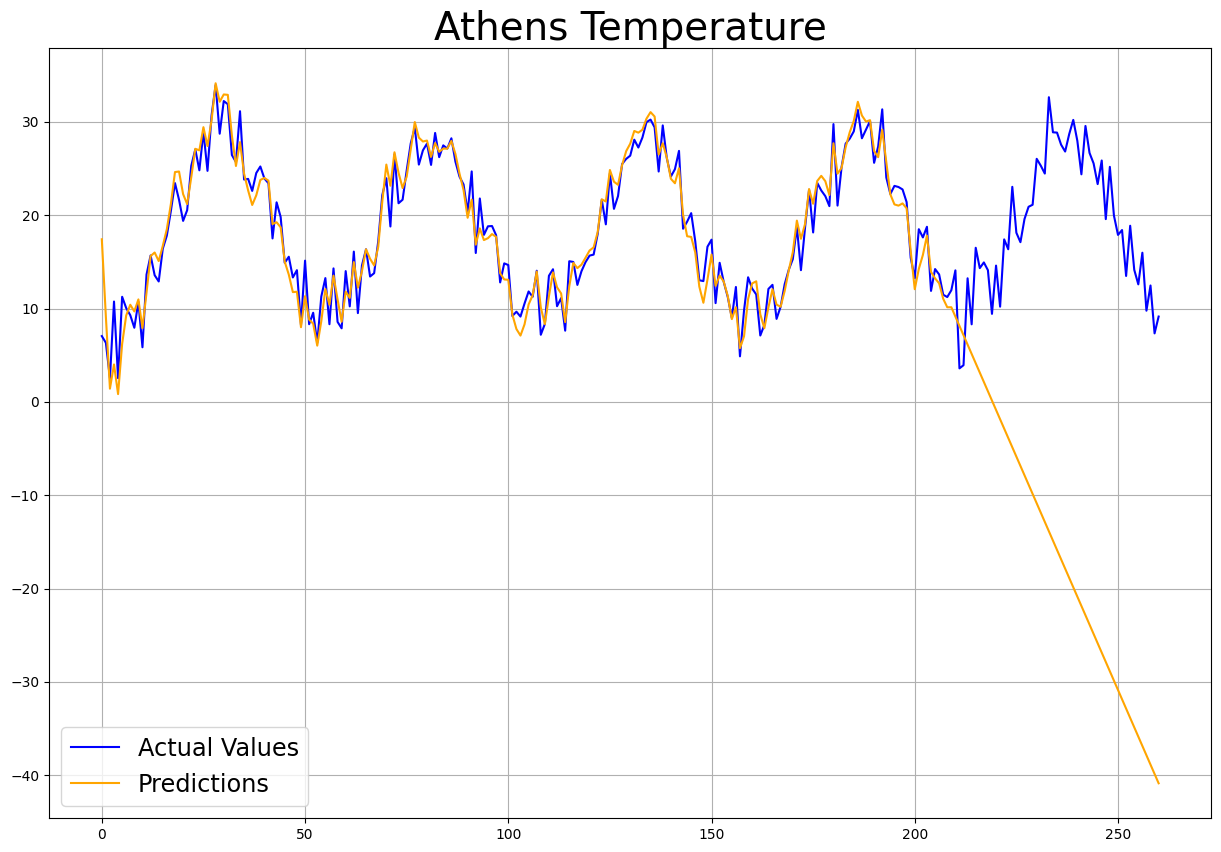

In [24]:
To, Lo = find_ab(np.array(train['Temperature']))

athens['TrendExpoSmooth 0.5, 0.5'] = trend_expo_smooth(np.array(train['Temperature']), forecast.shape[0], Lo, To, 0.5, 0.5)

plt.figure(figsize=(15,10))
plt.plot(athens["Temperature"], color = "blue",label='Actual Values')
plt.plot(athens['TrendExpoSmooth 0.5, 0.5'], color = "orange",label='Predictions')
plt.title('Athens Temperature', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

In [25]:
save_a = 0
save_b = 0
save_mad = 90000
save_all = np.array([])
for a in np.arange(0.01,1,0.01):
    for b in np.arange(0.01,1,0.01):
        temp_forecast = trend_expo_smooth(np.array(train['Temperature']), forecast.shape[0], Lo, To, a, b)
        mad1 = np.mean(np.abs(temp_forecast[-forecast.shape[0]:] - forecast['Temperature']))
        if mad1 < save_mad:
            save_mad = mad1
            save_a = a
            save_b = b
        save_all = np.append(save_all, np.round([a, b, mad1], 2))
    
save_all = np.reshape(save_all, (-1, 3))
print(f"Best a: {save_a}, Best b: {save_b} with Mean Absolute Deviation: {save_mad}")

Best a: 0.01, Best b: 0.08 with Mean Absolute Deviation: 6.083133758445792


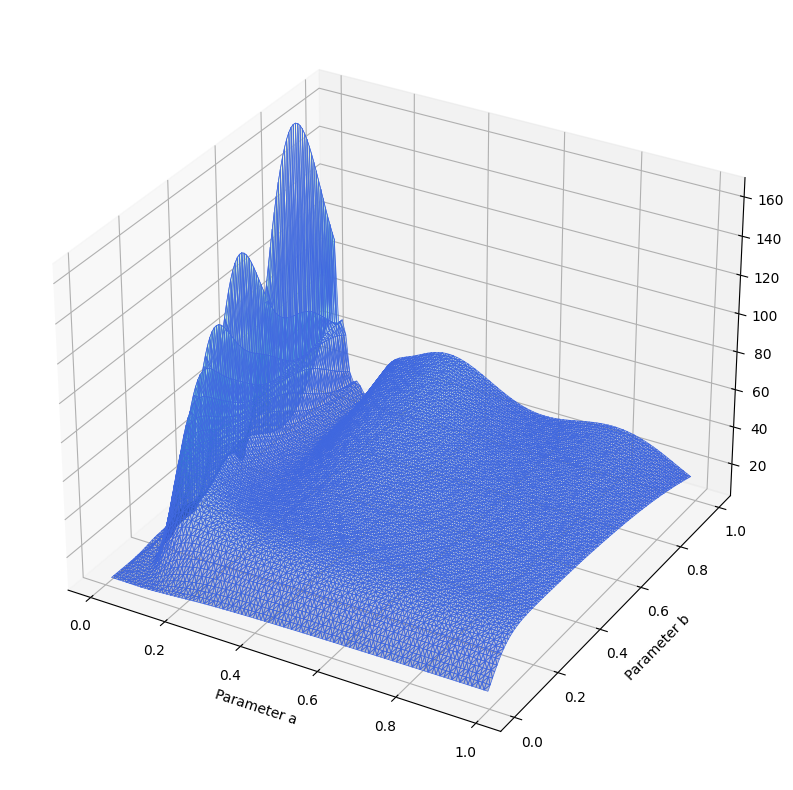

In [26]:
X, Y, Z = save_all[:, 0], save_all[:, 1], save_all[:, 2]
ax = plt.figure(figsize=(15,10)).add_subplot(projection='3d')
ax.plot_trisurf(X, Y, Z, edgecolor='royalblue', lw=0.5, cmap=plt.cm.YlGnBu_r, alpha=0.3)
ax.set(xlabel='Parameter a', ylabel='Parameter b')
plt.show()

<Axes: xlabel='Parameter b', ylabel='Parameter a'>

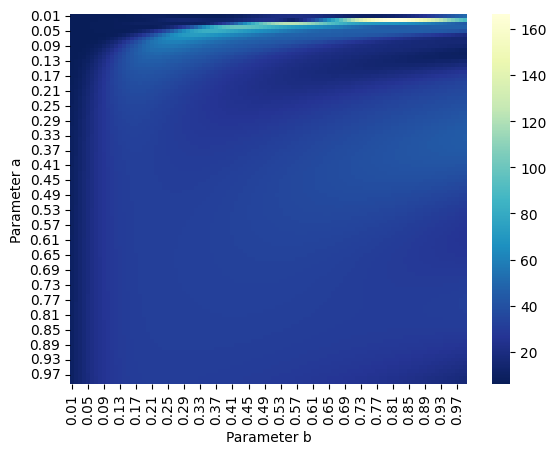

In [27]:
save_all1 = pd.DataFrame(save_all)
save_all1.columns = ['Parameter a','Parameter b','Mean Absolute Deviation']
pivotted = save_all1.pivot(index='Parameter a', columns='Parameter b', values='Mean Absolute Deviation')
sns.heatmap(pivotted,cmap=plt.cm.YlGnBu_r)

<Axes: xlabel='Parameter b', ylabel='Parameter a'>

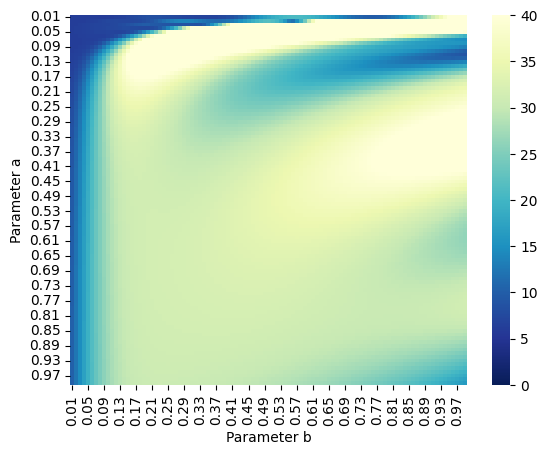

In [28]:
sns.heatmap(pivotted,cmap=plt.cm.YlGnBu_r, vmin=0, vmax=40)

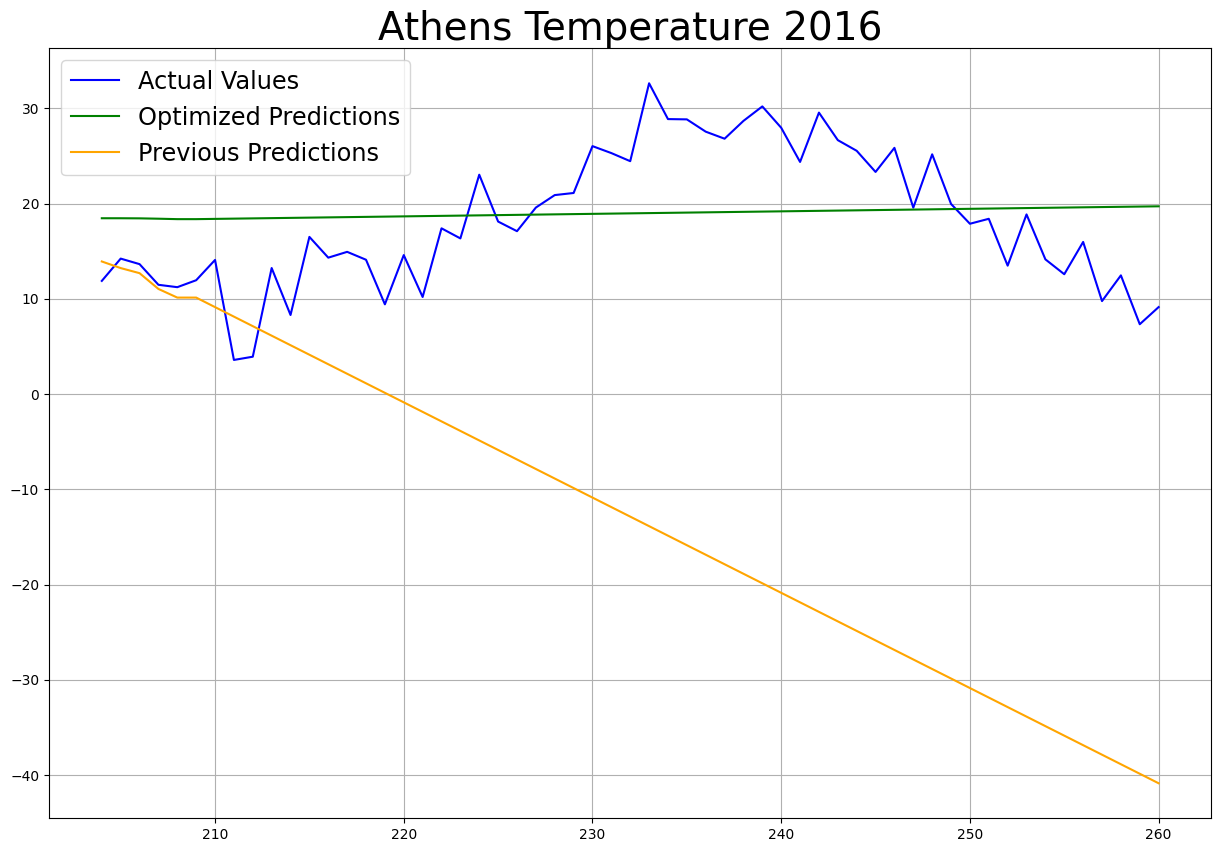

In [29]:
To, Lo = find_ab(np.array(train['Temperature']))

athens['TrendExpoSmooth 0.01, 0.08'] = trend_expo_smooth(np.array(train['Temperature']), forecast.shape[0], Lo, To, 0.01, 0.08)

plt.figure(figsize=(15,10))
plt.plot(athens["Temperature"][-(forecast.shape[0]+5):], color = "blue",label='Actual Values')
plt.plot(athens['TrendExpoSmooth 0.01, 0.08'][-(forecast.shape[0]+5):], color = "green",label='Optimized Predictions')
plt.plot(athens['TrendExpoSmooth 0.5, 0.5'][-(forecast.shape[0]+5):], color = "orange",label='Previous Predictions')
plt.title('Athens Temperature 2016', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

In [30]:
errors['mad']['TrendExpoSmooth 0.5, 0.5'] = np.round(mad(athens['TrendExpoSmooth 0.5, 0.5'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['mad']['TrendExpoSmooth 0.01, 0.08'] = np.round(mad(athens['TrendExpoSmooth 0.01, 0.08'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['mse']['TrendExpoSmooth 0.5, 0.5'] = np.round(mse(athens['TrendExpoSmooth 0.5, 0.5'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['mse']['TrendExpoSmooth 0.01, 0.08'] = np.round(mse(athens['TrendExpoSmooth 0.01, 0.08'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['rmse']['TrendExpoSmooth 0.5, 0.5'] = np.round(rmse(athens['TrendExpoSmooth 0.5, 0.5'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['rmse']['TrendExpoSmooth 0.01, 0.08'] = np.round(rmse(athens['TrendExpoSmooth 0.01, 0.08'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['mape']['TrendExpoSmooth 0.5, 0.5'] = str(np.round(mape(athens['TrendExpoSmooth 0.5, 0.5'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)) + '%'
errors['mape']['TrendExpoSmooth 0.01, 0.08'] = str(np.round(mape(athens['TrendExpoSmooth 0.01, 0.08'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)) + '%'

errors.head(7)

,mad,mse,rmse,mape
Moving Average 5,8.03,96.39,9.82,43.81%
Moving Average 62,5.44,41.71,6.46,46.15%
Exponential Smoothing 0.5,8.7,110.63,10.52,45.82%
Exponential Smoothing 0.01,6.61,63.74,7.98,45.48%
Naive Approach,8.71,110.62,10.52,45.84%
"TrendExpoSmooth 0.5, 0.5",34.52,1494.67,38.66,192.03%
"TrendExpoSmooth 0.01, 0.08",6.08,51.45,7.17,49.22%


## B. d) Forecasting Temperatures in Athens for the year 2016
### Seasonal Adjustment - Winter’s Model

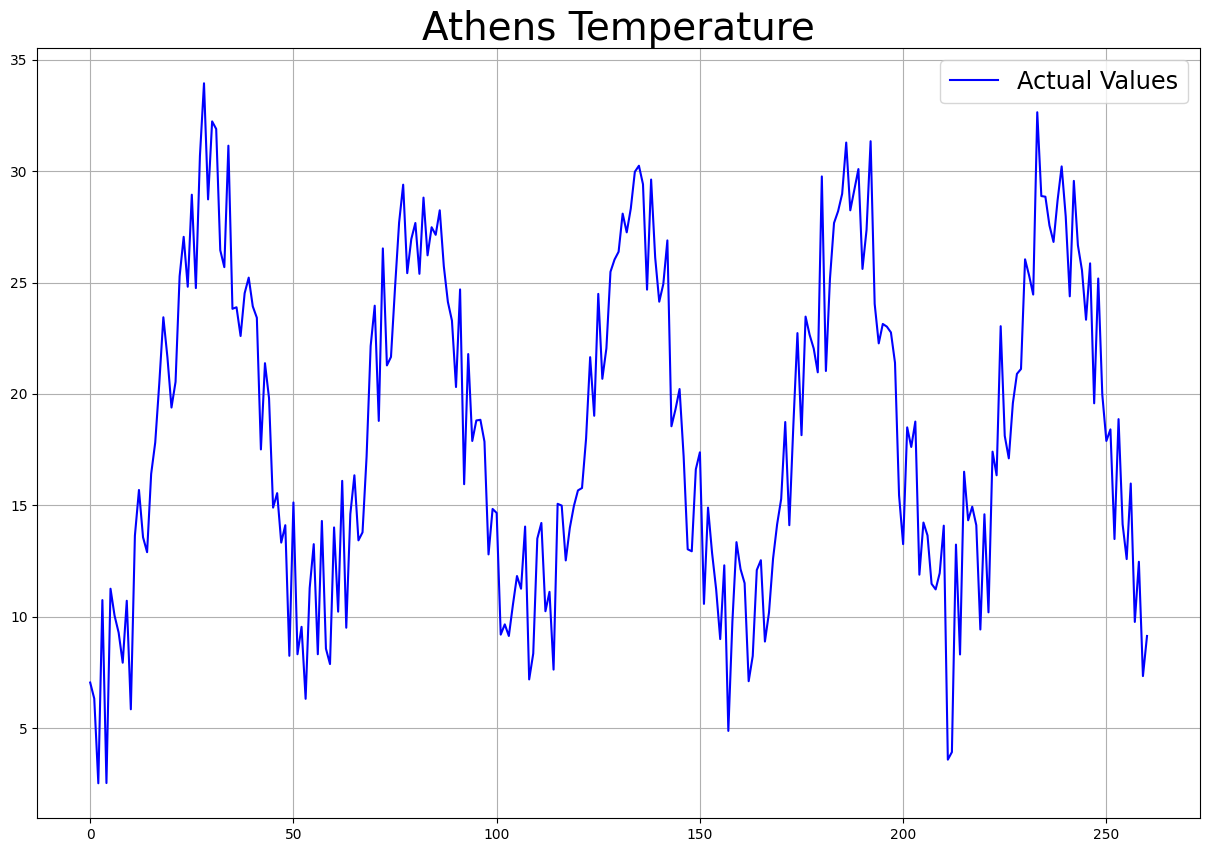

In [31]:
plt.figure(figsize=(15,10))
plt.plot(athens["Temperature"], color = "blue",label='Actual Values')
plt.title('Athens Temperature', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

In [32]:
season_window = 52

def season_expo_smooth(actual, periods, season_window, a, b, g):
    temp = actual[:season_window]
    St = np.array([])
    for i in temp:
        St = np.append(St, i/np.mean(temp))
    Lt = np.zeros(season_window)
    Tt = np.zeros(season_window)
    St = np.append(St, St[0])
    Lt = np.append(Lt, actual[season_window]/St[1]) # Initial Lt = Yt/St-52
    Tt = np.append(Tt, Lt[-1] - (actual[season_window-1]/St[0])) # Initial Tt = Lt – Lt-1
    for index, i in enumerate(actual[(season_window + 1):]):
        Lt = np.append(Lt, a * (i / St[index + 1]) + (1 - a) * (Lt[-1] + Tt[-1])) # Lt =  α(Yt/ St-m) + (1-α)[Lt-1 + Tt-1]
        Tt = np.append(Tt, b * (Lt[-1] - Lt[-2]) + (1 - b) * Tt[-1]) # Tt+1 =  β(Lt+1- Lt)  + (1-β) Tt
        St = np.append(St, g * (i / Lt[-2]) + (1 - g) * St[index + 1]) # St = γ(Yt / Lt) + (1-γ)St-m
    forecast = np.zeros(season_window)
    forecast = np.append(forecast, (Lt[season_window:] + Tt[season_window:]) * St[season_window:]) # Ŷt+1 = (Lt + Tt) x St
    for i in range(periods):
        forecast = np.append(forecast, (Lt[-1] + Tt[-1]*(i + 1)) * St[i])
    return forecast

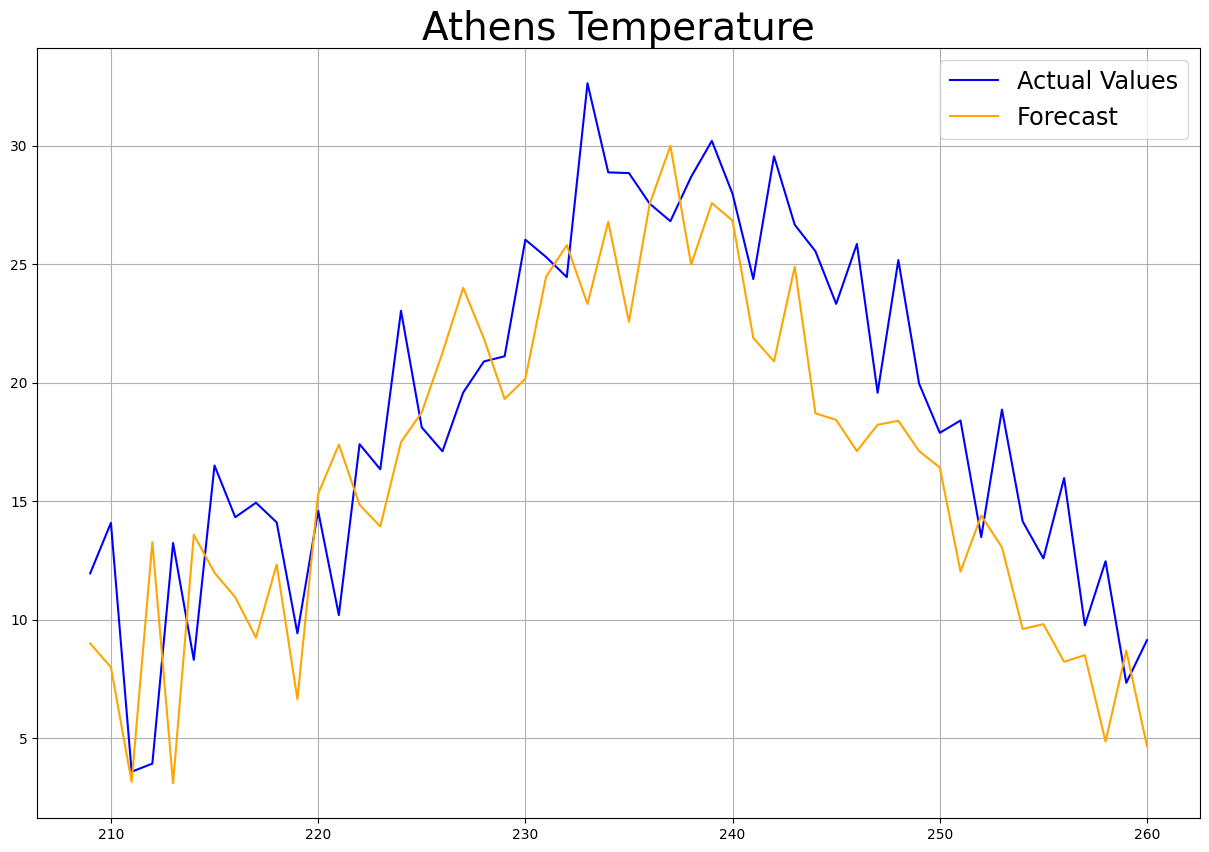

In [33]:
athens['SeasonExpoSmooth 0.5, 0.5, 0.5'] = season_expo_smooth(np.array(train['Temperature']), forecast.shape[0], season_window, 0.5, 0.5, 0.5)

plt.figure(figsize=(15,10))
plt.plot(athens["Temperature"][-forecast.shape[0]:], color = "blue",label='Actual Values')
plt.plot(athens['SeasonExpoSmooth 0.5, 0.5, 0.5'][-forecast.shape[0]:], color = "orange",label='Forecast')
plt.title('Athens Temperature', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

In [34]:
save_a = 0
save_b = 0
save_g = 0
save_mad = 90000
for a in np.arange(0.1,1,0.1):
    for b in np.arange(0.1,1,0.1):
        for g in np.arange(0.01,1,0.01):
            temp_forecast = season_expo_smooth(np.array(train['Temperature']), forecast.shape[0], season_window, a, b, g)
            mad1 = np.mean(np.abs(temp_forecast[-forecast.shape[0]:] - forecast['Temperature']))
            if mad1 < save_mad:
                save_mad = mad1
                save_a = a
                save_b = b
                save_g = g

print(f"Best a: {save_a}, Best b: {save_b}, Best g: {save_g} with Mean Absolute Deviation: {save_mad}")

Best a: 0.6, Best b: 0.30000000000000004, Best g: 0.59 with Mean Absolute Deviation: 3.410311071408593


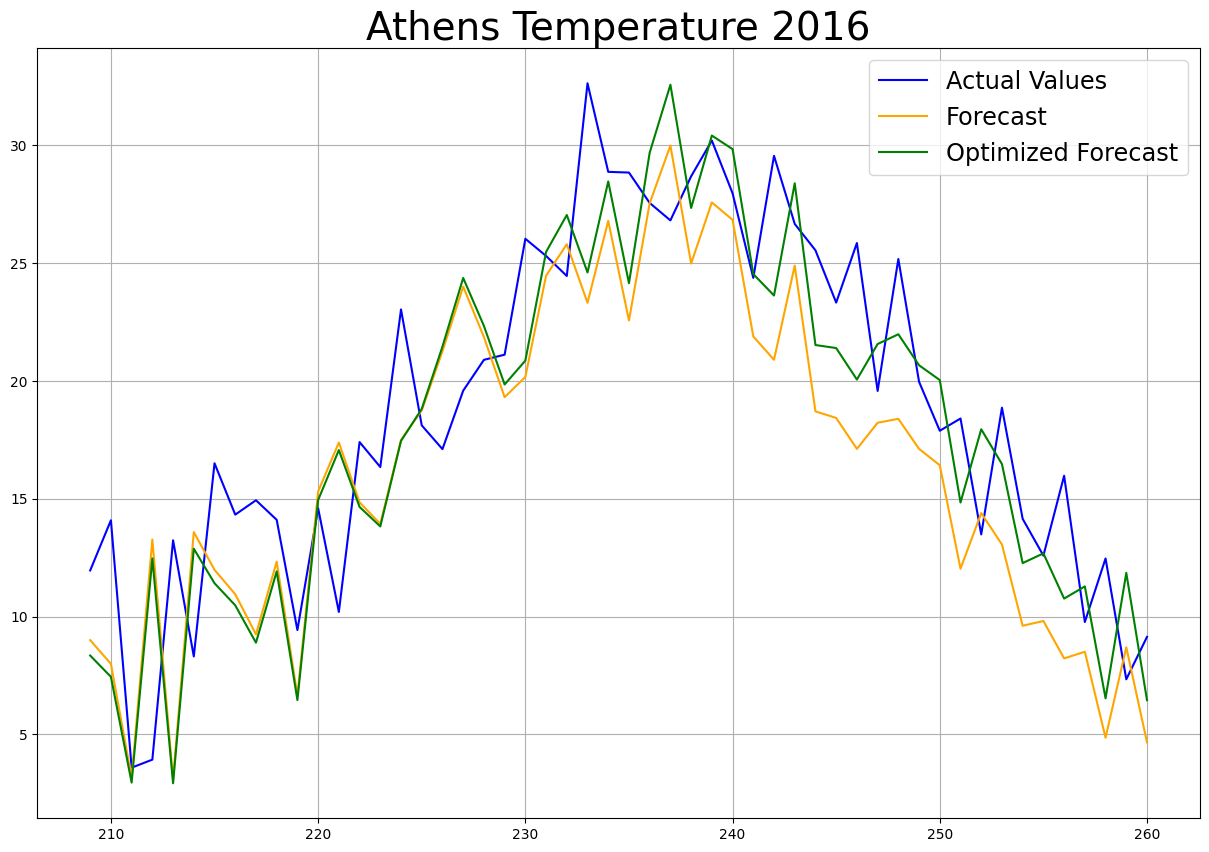

In [35]:
athens['Optimized SeasonExpoSmooth'] = season_expo_smooth(np.array(train['Temperature']), forecast.shape[0], season_window, 0.6, 0.3, 0.59)

plt.figure(figsize=(15,10))
plt.plot(athens["Temperature"][-(forecast.shape[0]):], color = "blue",label='Actual Values')
plt.plot(athens['SeasonExpoSmooth 0.5, 0.5, 0.5'][-(forecast.shape[0]):], color = "orange",label='Forecast')
plt.plot(athens['Optimized SeasonExpoSmooth'][-(forecast.shape[0]):], color = "green",label='Optimized Forecast')
plt.title('Athens Temperature 2016', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

In [36]:
errors['mad']['SeasonExpoSmooth 0.5, 0.5, 0.5'] = np.round(mad(athens['SeasonExpoSmooth 0.5, 0.5, 0.5'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['mad']['Optimized SeasonExpoSmooth'] = np.round(mad(athens['Optimized SeasonExpoSmooth'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['mse']['SeasonExpoSmooth 0.5, 0.5, 0.5'] = np.round(mse(athens['SeasonExpoSmooth 0.5, 0.5, 0.5'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['mse']['Optimized SeasonExpoSmooth'] = np.round(mse(athens['Optimized SeasonExpoSmooth'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['rmse']['SeasonExpoSmooth 0.5, 0.5, 0.5'] = np.round(rmse(athens['SeasonExpoSmooth 0.5, 0.5, 0.5'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['rmse']['Optimized SeasonExpoSmooth'] = np.round(rmse(athens['Optimized SeasonExpoSmooth'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)
errors['mape']['SeasonExpoSmooth 0.5, 0.5, 0.5'] = str(np.round(mape(athens['SeasonExpoSmooth 0.5, 0.5, 0.5'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)) + '%'
errors['mape']['Optimized SeasonExpoSmooth'] = str(np.round(mape(athens['Optimized SeasonExpoSmooth'][-forecast.shape[0]:], athens["Temperature"][-forecast.shape[0]:]), 2)) + '%'

errors.head(9)

,mad,mse,rmse,mape
Moving Average 5,8.03,96.39,9.82,43.81%
Moving Average 62,5.44,41.71,6.46,46.15%
Exponential Smoothing 0.5,8.7,110.63,10.52,45.82%
Exponential Smoothing 0.01,6.61,63.74,7.98,45.48%
Naive Approach,8.71,110.62,10.52,45.84%
"TrendExpoSmooth 0.5, 0.5",34.52,1494.67,38.66,192.03%
"TrendExpoSmooth 0.01, 0.08",6.08,51.45,7.17,49.22%
"SeasonExpoSmooth 0.5, 0.5, 0.5",4.0,23.27,4.82,27.07%
Optimized SeasonExpoSmooth,3.41,17.22,4.15,24.52%


# C. Forecasting Temperatures in Amsterdam for the year 2016

## Importing - Processing Data

In [37]:
cities = ['Amsterdam',
           'Antwerp',
           'Bordeaux',
           'Dusseldorf',
           'Edinburgh',
           'Ghent',
           'Glasgow',
           'Luxembourg',
           'Lyon',
           'Newscastle',
           'Paris']

citiesdf = pd.DataFrame()
for city in cities:
    citydf = pd.read_csv(f'CSVs/{city}.csv')
    citiesdf[f"{city}"] = citydf['Values_Celsius']

citiesdf['Year'] = citydf['Source CSV'].str.split('_').str[0]
citiesdf['Month'] = citydf['Source CSV'].str.split('_').str[1]

citiesdf.head(20)

,Amsterdam,Antwerp,Bordeaux,Dusseldorf,Edinburgh,Ghent,Glasgow,Luxembourg,Lyon,Newscastle,Paris,Year,Month
0,7.22110,7.58355,9.87040,8.07693,2.94665,7.15170,2.95187,7.19656,8.97646,3.73174,8.68173,2012,01
1,-4.97956,-4.92206,-1.34803,-6.48975,4.49377,-4.32813,4.82720,-8.35505,-5.94922,4.16076,-2.59037,2012,02
2,6.29705,5.43408,6.27157,6.13060,4.38680,4.34490,4.56472,2.74062,4.85864,3.95825,5.57812,2012,03
3,8.72370,8.46877,13.46157,7.44590,6.47576,8.13622,7.35632,7.47405,13.27337,7.80734,10.27776,2012,04
4,9.84817,10.76235,15.26418,9.97200,6.38330,10.89404,5.52170,10.22912,13.97410,6.58350,12.91760,2012,05
5,9.75497,10.69982,17.24053,11.42440,9.65770,11.01260,10.04138,11.94140,15.96820,9.49908,14.58587,2012,06
6,17.26656,17.35406,18.25768,17.33758,12.96588,17.10030,13.39770,16.49877,17.15377,14.48750,18.94090,2012,07
7,16.70420,16.96023,19.07437,18.33990,14.06360,16.44027,14.24000,16.43408,19.22840,14.96243,17.95696,2012,08
8,18.36526,18.84738,20.13497,17.57443,15.75906,18.47195,15.90322,17.57210,19.14870,16.42224,19.08257,2012,09
9,14.40756,14.35140,14.37057,12.68597,10.49380,13.93880,10.03912,11.59832,14.84457,11.54977,14.38003,2012,10


In [38]:
### Creating 2 dataframes for: years 2012-2015 and year 2016
# Split the DataFrame into two based on the 'Year'
citiesdf['Year'] = citiesdf['Year'].astype(int)
citiesdf = citiesdf[citiesdf['Year'].between(2012, 2016)].copy().reset_index(drop=True)
trainC = citiesdf[citiesdf['Year'].between(2012, 2015)].copy().reset_index(drop=True)
forecastC = citiesdf[citiesdf['Year'] == 2016].copy().reset_index(drop=True)

print("DataFrame for 2012-2015:")
trainC.head()

DataFrame for 2012-2015:


,Amsterdam,Antwerp,Bordeaux,Dusseldorf,Edinburgh,Ghent,Glasgow,Luxembourg,Lyon,Newscastle,Paris,Year,Month
0,7.22110,7.58355,9.87040,8.07693,2.94665,7.15170,2.95187,7.19656,8.97646,3.73174,8.68173,2012,01
1,-4.97956,-4.92206,-1.34803,-6.48975,4.49377,-4.32813,4.82720,-8.35505,-5.94922,4.16076,-2.59037,2012,02
2,6.29705,5.43408,6.27157,6.13060,4.38680,4.34490,4.56472,2.74062,4.85864,3.95825,5.57812,2012,03
3,8.72370,8.46877,13.46157,7.44590,6.47576,8.13622,7.35632,7.47405,13.27337,7.80734,10.27776,2012,04
4,9.84817,10.76235,15.26418,9.97200,6.38330,10.89404,5.52170,10.22912,13.97410,6.58350,12.91760,2012,05


In [39]:
print("DataFrame for 2016:")
forecastC.head()

DataFrame for 2016:


,Amsterdam,Antwerp,Bordeaux,Dusseldorf,Edinburgh,Ghent,Glasgow,Luxembourg,Lyon,Newscastle,Paris,Year,Month
0,5.63046,6.57235,9.22560,5.67196,6.27804,6.59090,6.27935,4.18728,8.11392,6.33486,7.84286,2016,01
1,10.01210,10.73570,11.84910,10.23232,6.68157,10.62246,6.97216,8.90847,11.41805,8.18658,11.57687,2016,02
2,3.40950,2.36178,6.45724,1.95608,1.38485,1.94412,1.86273,0.87817,3.22363,1.60653,3.62150,2016,03
3,12.49658,12.95710,11.60418,13.79880,7.03010,12.32784,7.23913,11.67800,12.98773,8.63700,13.31802,2016,04
4,10.99910,11.35748,11.00253,12.70934,8.82867,10.53054,8.68010,11.32678,12.30743,9.73590,12.39660,2016,05


## Forecasting Temperatures in Amsterdam for the year 2016
### Winter's Model

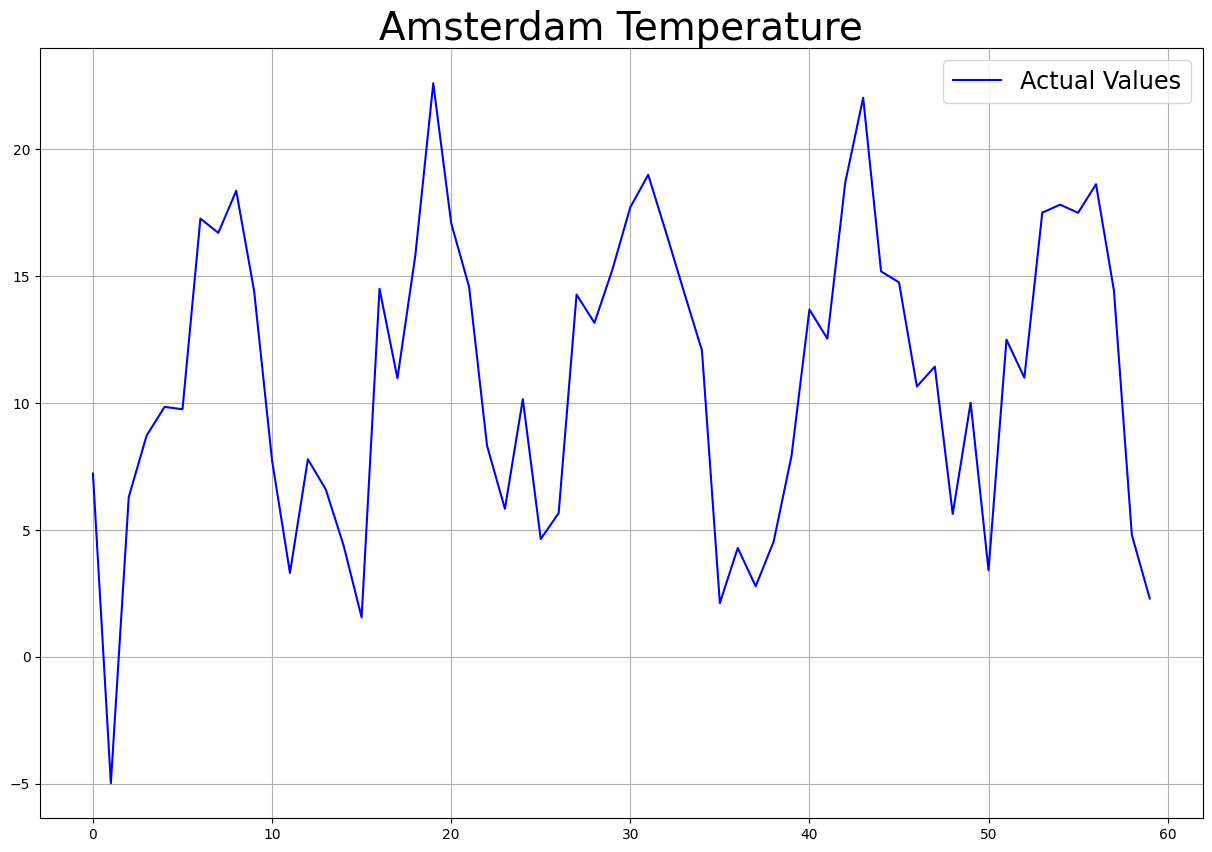

In [40]:
plt.figure(figsize=(15,10))
plt.plot(citiesdf["Amsterdam"], color = "blue",label='Actual Values')
plt.title('Amsterdam Temperature', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

In [41]:
season_window = 12

save_a = 0
save_b = 0
save_g = 0
save_mad = 90000
for a in np.arange(0.1,1,0.1):
    for b in np.arange(0.1,1,0.1):
        for g in np.arange(0.01,1,0.01):
            temp_forecast = season_expo_smooth(np.array(trainC['Amsterdam']), forecastC.shape[0], season_window, a, b, g)
            mad1 = np.mean(np.abs(temp_forecast[-forecastC.shape[0]:] - forecastC['Amsterdam']))
            if mad1 < save_mad:
                save_mad = mad1
                save_a = a
                save_b = b
                save_g = g
    

print(f"Best a: {save_a}, Best b: {save_b}, Best g: {save_g} with Mean Absolute Deviation: {save_mad}")

Best a: 0.2, Best b: 0.30000000000000004, Best g: 0.11 with Mean Absolute Deviation: 3.1459611851644476


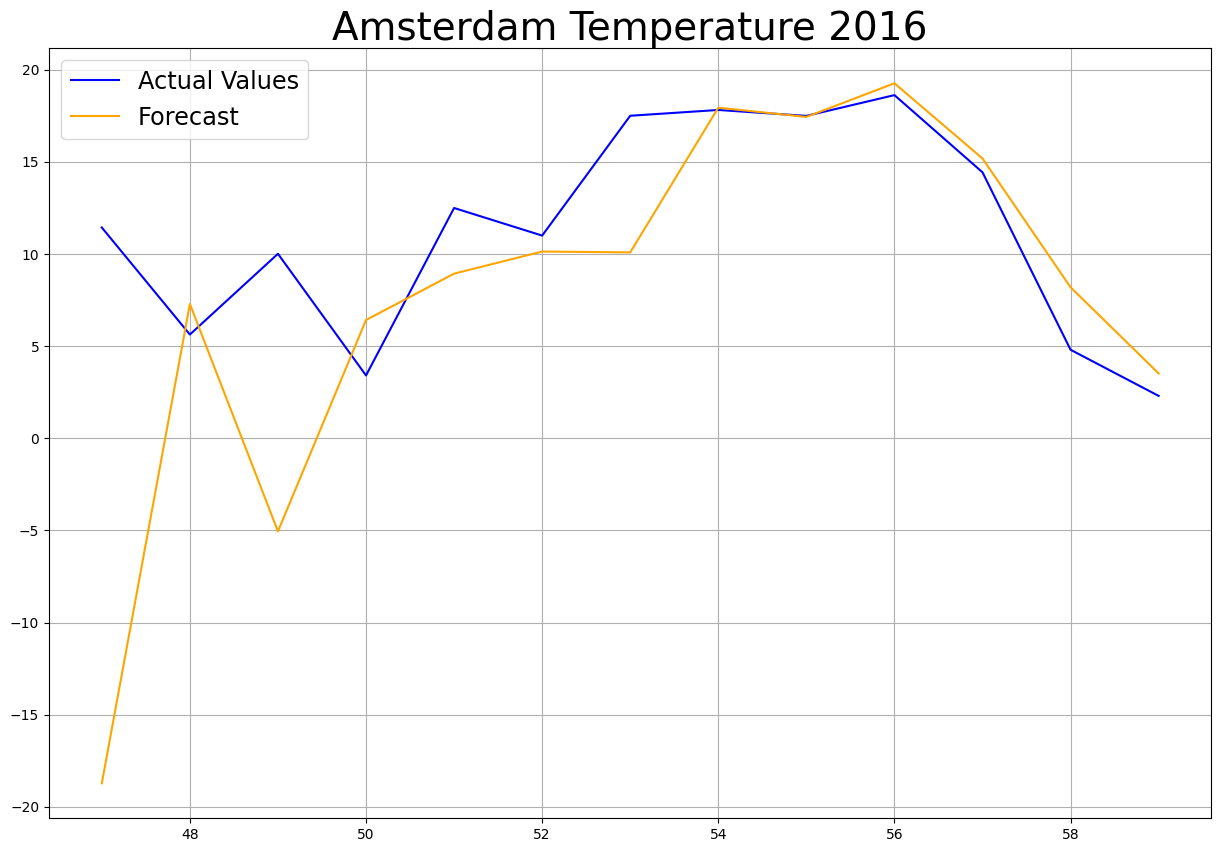

In [42]:
citiesdf['AmsterdamF'] = season_expo_smooth(np.array(trainC['Amsterdam']), forecastC.shape[0], 12, 0.2, 0.3, 0.11)

plt.figure(figsize=(15,10))
plt.plot(citiesdf['Amsterdam'][-(forecastC.shape[0]+1):], color = "blue",label='Actual Values')
plt.plot(citiesdf['AmsterdamF'][-(forecastC.shape[0]+1):], color = "orange",label='Forecast')
plt.title('Amsterdam Temperature 2016', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

## Forecasting Temperatures of 10 Northwestern European Cities for 2016
### Winter's Model

In [43]:
for city in cities:
    if city != 'Amsterdam':
        save_a = 0
        save_b = 0
        save_g = 0
        save_mad = 90000
        for a in np.arange(0.1,1,0.1):
            for b in np.arange(0.1,1,0.1):
                for g in np.arange(0.01,1,0.01):
                    temp_forecast = season_expo_smooth(np.array(trainC[f"{city}"]), forecastC.shape[0], 12, a, b, g)
                    mad1 = np.mean(np.abs(temp_forecast[-forecastC.shape[0]:] - forecastC[f"{city}"]))
                    if mad1 < save_mad:
                        save_mad = mad1
                        save_a = a
                        save_b = b
                        save_g = g
        citiesdf[f"{city}F"] = season_expo_smooth(np.array(trainC[f"{city}"]), forecastC.shape[0], 12, save_a, save_b, save_g)
        citiesdf[f"{city} A/F ratio"] = citiesdf[f"{city}"]/citiesdf[f"{city}F"]

citiesdf['mean'] = (citiesdf[f"{cities[1]} A/F ratio"] + citiesdf[f"{cities[2]} A/F ratio"] + citiesdf[f"{cities[3]} A/F ratio"] + citiesdf[f"{cities[4]} A/F ratio"] + citiesdf[f"{cities[5]} A/F ratio"] + citiesdf[f"{cities[6]} A/F ratio"] + citiesdf[f"{cities[7]} A/F ratio"] + citiesdf[f"{cities[8]} A/F ratio"] + citiesdf[f"{cities[9]} A/F ratio"] + citiesdf[f"{cities[10]} A/F ratio"]) / 10
citiesdf.tail()

,Amsterdam,Antwerp,Bordeaux,Dusseldorf,Edinburgh,Ghent,Glasgow,Luxembourg,Lyon,Newscastle,...,Glasgow A/F ratio,LuxembourgF,Luxembourg A/F ratio,LyonF,Lyon A/F ratio,NewscastleF,Newscastle A/F ratio,ParisF,Paris A/F ratio,mean
55,17.49392,17.56048,20.77703,17.40286,13.61672,17.18777,14.01794,17.13894,21.94726,15.29740,...,0.939372,16.669093,1.028187,20.283108,1.082046,15.971051,0.957821,17.716311,1.139207,1.012675
56,18.62118,18.61022,22.46215,17.97296,15.50310,18.39227,16.43630,16.46285,20.70684,16.83840,...,0.997471,17.391206,0.946619,20.557408,1.007269,16.773884,1.003846,18.960706,1.029532,0.995185
57,14.43353,14.29797,16.79357,13.39672,10.13125,13.69335,10.56915,11.02783,13.68908,11.36788,...,1.027780,11.193665,0.985185,16.214456,0.844252,11.265820,1.009059,14.389077,1.007530,0.987539
58,4.80425,5.00012,7.67227,4.60815,3.96374,4.78185,3.06896,2.42947,4.77404,4.47305,...,1.074363,5.603501,0.433563,10.726088,0.445087,4.600245,0.972350,8.698863,0.534047,0.692471
59,2.30084,1.01248,10.82897,0.27133,2.83727,0.54696,1.24267,-0.32650,7.26790,5.04452,...,0.435463,0.985934,-0.331158,3.054234,2.379615,2.443469,2.064491,7.070098,0.890621,0.784474


## Adjusting Amsterdam's Forecast
### Using A/F ratios

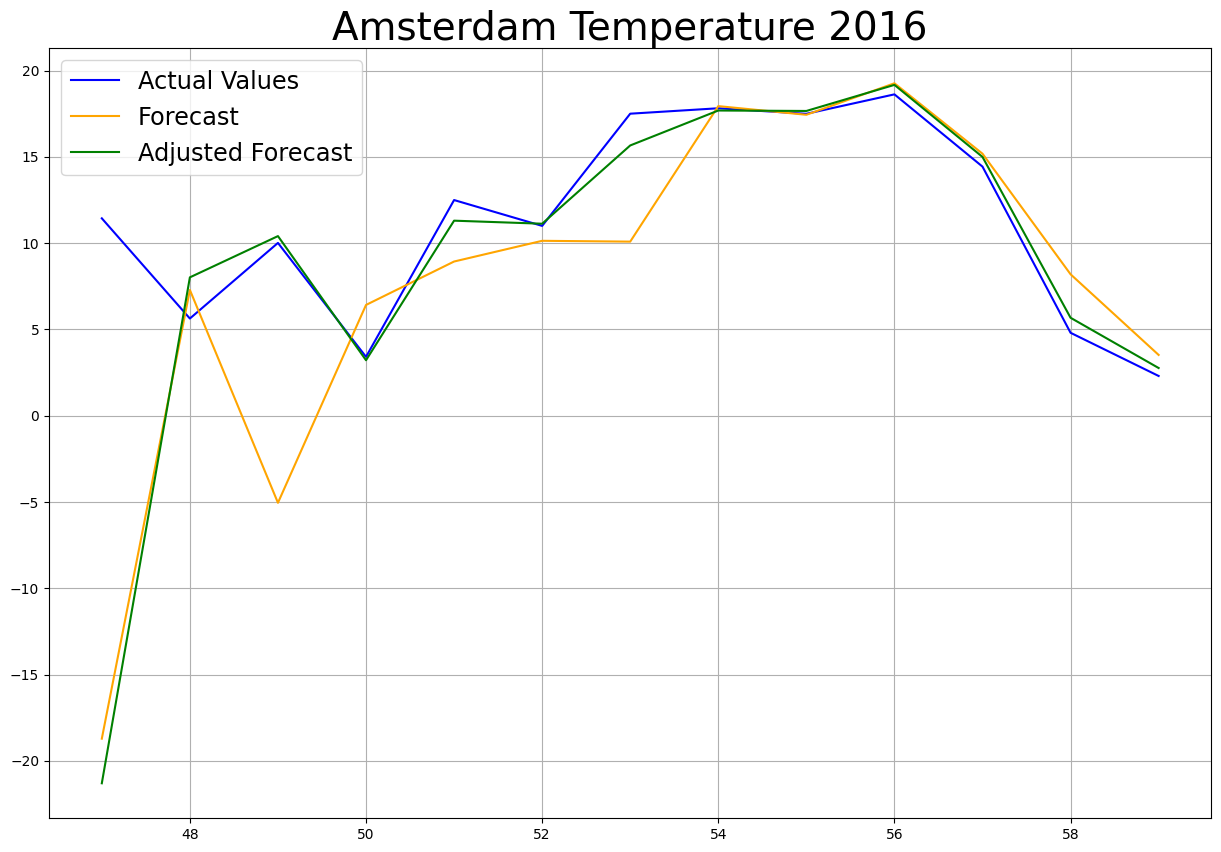

In [44]:
citiesdf['Amsterdam Expected'] = citiesdf['AmsterdamF']*citiesdf['mean']

plt.figure(figsize=(15,10))
plt.plot(citiesdf['Amsterdam'][-(forecastC.shape[0]+1):], color = "blue",label='Actual Values')
plt.plot(citiesdf['AmsterdamF'][-(forecastC.shape[0]+1):], color = "orange",label='Forecast')
plt.plot(citiesdf['Amsterdam Expected'][-(forecastC.shape[0]+1):], color = "green",label='Adjusted Forecast')
plt.title('Amsterdam Temperature 2016', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

## Error Estimations

In [45]:
errors['mad']['Amsterdam Forecast'] = np.round(mad(citiesdf['AmsterdamF'][-forecastC.shape[0]:], citiesdf['Amsterdam'][-forecastC.shape[0]:]), 2)
errors['mad']['Amsterdam Improved Forecast'] = np.round(mad(citiesdf['Amsterdam Expected'][-forecastC.shape[0]:], citiesdf['Amsterdam'][-forecastC.shape[0]:]), 2)
errors['mse']['Amsterdam Forecast'] = np.round(mse(citiesdf['AmsterdamF'][-forecastC.shape[0]:], citiesdf['Amsterdam'][-forecastC.shape[0]:]), 2)
errors['mse']['Amsterdam Improved Forecast'] = np.round(rmse(citiesdf['Amsterdam Expected'][-forecastC.shape[0]:], citiesdf['Amsterdam'][-forecastC.shape[0]:]), 2)
errors['rmse']['Amsterdam Forecast'] = np.round(rmse(citiesdf['AmsterdamF'][-forecastC.shape[0]:], citiesdf['Amsterdam'][-forecastC.shape[0]:]), 2)
errors['rmse']['Amsterdam Improved Forecast'] = np.round(rmse(citiesdf['Amsterdam Expected'][-forecastC.shape[0]:], citiesdf['Amsterdam'][-forecastC.shape[0]:]), 2)
errors['mape']['Amsterdam Forecast'] = str(np.round(mape(citiesdf['AmsterdamF'][-forecastC.shape[0]:], citiesdf['Amsterdam'][-forecastC.shape[0]:]), 2)) + '%'
errors['mape']['Amsterdam Improved Forecast'] = str(np.round(mape(citiesdf['Amsterdam Expected'][-forecastC.shape[0]:], citiesdf['Amsterdam'][-forecastC.shape[0]:]), 2)) + '%'

errors.head(11)

,mad,mse,rmse,mape
Moving Average 5,8.03,96.39,9.82,43.81%
Moving Average 62,5.44,41.71,6.46,46.15%
Exponential Smoothing 0.5,8.7,110.63,10.52,45.82%
Exponential Smoothing 0.01,6.61,63.74,7.98,45.48%
Naive Approach,8.71,110.62,10.52,45.84%
"TrendExpoSmooth 0.5, 0.5",34.52,1494.67,38.66,192.03%
"TrendExpoSmooth 0.01, 0.08",6.08,51.45,7.17,49.22%
"SeasonExpoSmooth 0.5, 0.5, 0.5",4.0,23.27,4.82,27.07%
Optimized SeasonExpoSmooth,3.41,17.22,4.15,24.52%
Amsterdam Forecast,3.15,26.75,5.17,40.01%


## Comparing Forecast With The Average Temperature In NW Europe

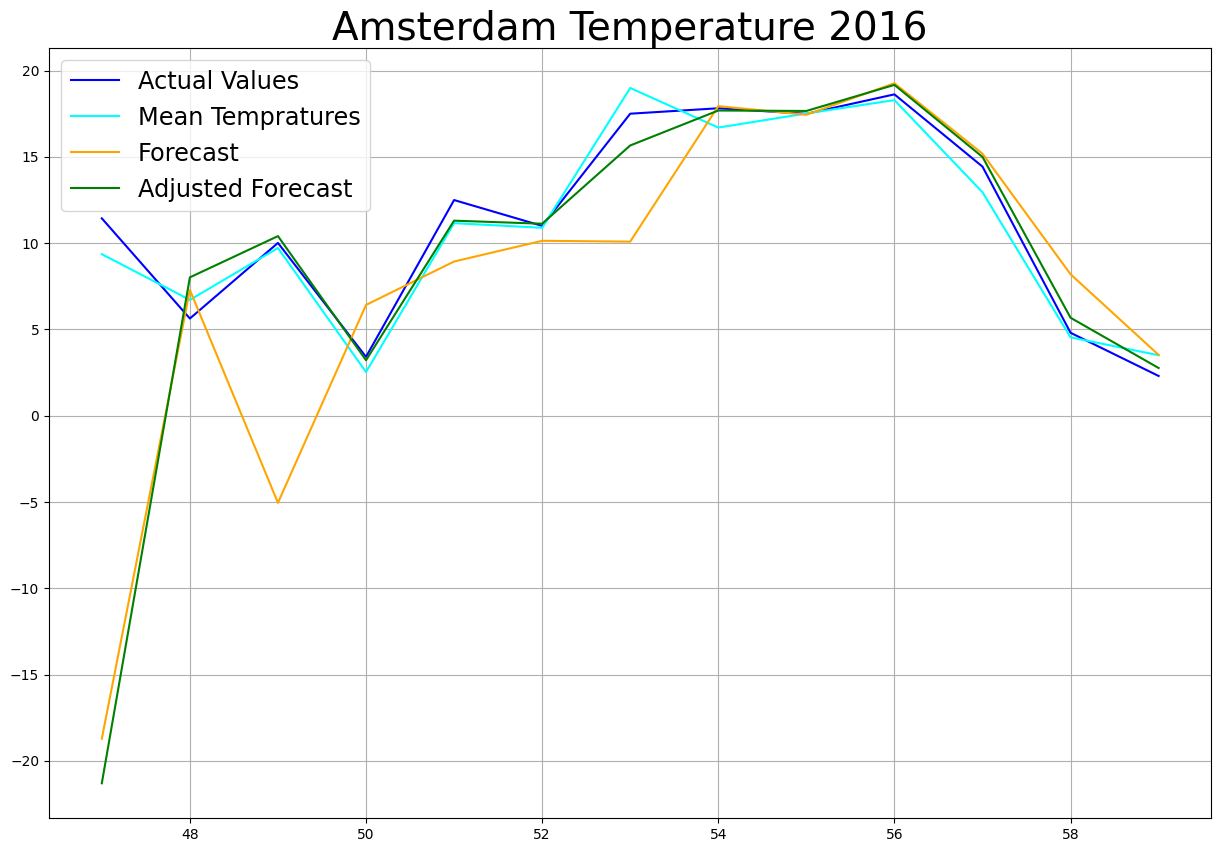

In [46]:
citiesdf['Mean Temperatures'] = 0
for city in cities:
    if city != 'Amsterdam':
        citiesdf['Mean Temperatures'] += citiesdf[f"{city}"]

citiesdf['Mean Temperatures'] = citiesdf['Mean Temperatures'] / 10

plt.figure(figsize=(15,10))
plt.plot(citiesdf['Amsterdam'][-(forecastC.shape[0]+1):], color = "blue",label='Actual Values')
plt.plot(citiesdf['Mean Temperatures'][-(forecastC.shape[0]+1):], color = "cyan",label='Mean Tempratures')
plt.plot(citiesdf['AmsterdamF'][-(forecastC.shape[0]+1):], color = "orange",label='Forecast')
plt.plot(citiesdf['Amsterdam Expected'][-(forecastC.shape[0]+1):], color = "green",label='Adjusted Forecast')
plt.title('Amsterdam Temperature 2016', size=28, color="black")
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

In [47]:
errors['mad']['Mean Temperatures'] = np.round(mad(citiesdf['Mean Temperatures'][-forecastC.shape[0]:], citiesdf['Amsterdam'][-forecastC.shape[0]:]), 2)
errors['mse']['Mean Temperatures'] = np.round(mse(citiesdf['Mean Temperatures'][-forecastC.shape[0]:], citiesdf['Amsterdam'][-forecastC.shape[0]:]), 2)
errors['rmse']['Mean Temperatures'] = np.round(rmse(citiesdf['Mean Temperatures'][-forecastC.shape[0]:], citiesdf['Amsterdam'][-forecastC.shape[0]:]), 2)
errors['mape']['Mean Temperatures'] = str(np.round(mape(citiesdf['Mean Temperatures'][-forecastC.shape[0]:], citiesdf['Amsterdam'][-forecastC.shape[0]:]), 2)) + '%'

errors

,mad,mse,rmse,mape
Moving Average 5,8.03,96.39,9.82,43.81%
Moving Average 62,5.44,41.71,6.46,46.15%
Exponential Smoothing 0.5,8.7,110.63,10.52,45.82%
Exponential Smoothing 0.01,6.61,63.74,7.98,45.48%
Naive Approach,8.71,110.62,10.52,45.84%
"TrendExpoSmooth 0.5, 0.5",34.52,1494.67,38.66,192.03%
"TrendExpoSmooth 0.01, 0.08",6.08,51.45,7.17,49.22%
"SeasonExpoSmooth 0.5, 0.5, 0.5",4.0,23.27,4.82,27.07%
Optimized SeasonExpoSmooth,3.41,17.22,4.15,24.52%
Amsterdam Forecast,3.15,26.75,5.17,40.01%


# END